# Obligatorio - Taller Agentes Inteligentes 2023

Vamos a usar el juego Super Mario Bros:
PyPi: https://pypi.org/project/gym-super-mario-bros/ 
Repo: https://github.com/Kautenja/gym-super-mario-bros

En este caso, el juego está programado como un ambiente de OpenAI Gym, cumpliendo con las interfaces que hemos trabajado en el curso.


El objetivo del juego consta de lograr que nuestro personaje llegue al final de la pantalla, sin ser comido por enemigos o caer al vacío.

![](./assets/images/mario.gif)

Si bien el juego podría considerarse de múltiples agentes (mario, y sus enemigos), utilizaremos unicamente las heramientas del curso para solucionarlo, esto es, todo lo que no conforma a nuestros agentes será considerado ambiente y tratado como tal.

El objetivo es resolver el juego utilizando Deep Q Learning y Double Deep Q Learning, comparando sus resultados.


## Tareas:


1. Completar el código faltante en este notebook (y archivos asociados).


2. Entrenar un agente de Deep Q Learning (DQN) para cada ambiente tal que éste sea capaz de resolverlo.


3. Entrenar un agente de Double Deep Q Learning (DDQN) para cada ambiente tal que éste sea capaz de resolverlo.


4. Graficar las recompensas obtenidas para cada ambiente por cada agente (Ambos agentes resolviendo el ambiente 1 en una misma gráfica, idem para el ambiente 2). Escribir al menos 2 conclusiones de cada grafica. 


5. Grabar un video de cada agente resolviendo cada problema (pueden descargar el video desde colab y entregarlos dentro de un zip).


Recuerden que pueden usar la GPU en google colab para agilizar el entrenamiento. 
***


Fecha de entrega: **04/07** 21hs por gestión (gestion.ort.edu.uy). Pueden trabajar en grupos de hasta 3 estudiantes. 
***

Instalación de librerías. Se fija la versión de gym, dado que para dicha versión las ROMS de los juegos ya estan includias y se evita su instalación separada lo que puede originar problemas.

In [1]:
# %pip install pyvirtualdisplay > /dev/null 2>&1
# # !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
# %pip install opencv-python
# %pip install torchsummary
# %pip install nes-py
# %pip install --force-reinstall gym-super-mario-bros==7.4.0  > /dev/null 2>&1
# %pip install --force-reinstall gym==0.15.3 > /dev/null 2>&1
# %pip install pillow==8.4.0
# %pip install torchvision==0.11.1
# %pip install pyglet==1.4.9
# %pip install matplotlib


Imports y configuraciones de ambiente

In [2]:
# %pip install matplotlib
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# %pip install tensorboard


In [3]:
import os
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt

import math
import random
import numpy as np
from PIL import Image
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import mario_utils

Checkeo de devices

In [4]:
torch.zeros(1).cuda()

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Running on {DEVICE}")

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

print("Cuda Available:", torch.cuda.is_available())

Running on cuda:0
Cuda Available: True


Setting de seeds

In [5]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

Validacion del ambiente

In [6]:
ENV_NAME = "SuperMarioBros-1-1-v0"

env = mario_utils.make_env(ENV_NAME)
print("Actions #",env.action_space.n)
print(env.observation_space.shape)
env.reset()
next_state, reward, done, info = env.step(action=0)

print(f"{next_state.shape},\n {reward},\n {done},\n {info}")

Actions # 4
(4, 84, 84)
(4, 84, 84),
 0.0,
 False,
 {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'y_pos': 79}


In [7]:
next_state, reward, done, info = env.step(action=0)
torch.Tensor(next_state[:])

tensor([[[0.5476, 0.5476, 0.5476,  ..., 0.5476, 0.5476, 0.5476],
         [0.5476, 0.5476, 0.5476,  ..., 0.5476, 0.5476, 0.5476],
         [0.5476, 0.5476, 0.5476,  ..., 0.5476, 0.5476, 0.5476],
         ...,
         [0.5139, 0.4821, 0.4289,  ..., 0.4179, 0.5244, 0.3834],
         [0.5105, 0.4104, 0.3936,  ..., 0.4269, 0.5088, 0.3655],
         [0.4673, 0.3894, 0.4081,  ..., 0.4608, 0.3637, 0.2334]],

        [[0.5476, 0.5476, 0.5476,  ..., 0.5476, 0.5476, 0.5476],
         [0.5476, 0.5476, 0.5476,  ..., 0.5476, 0.5476, 0.5476],
         [0.5476, 0.5476, 0.5476,  ..., 0.5476, 0.5476, 0.5476],
         ...,
         [0.5139, 0.4821, 0.4289,  ..., 0.4179, 0.5244, 0.3834],
         [0.5105, 0.4104, 0.3936,  ..., 0.4269, 0.5088, 0.3655],
         [0.4673, 0.3894, 0.4081,  ..., 0.4608, 0.3637, 0.2334]],

        [[0.5476, 0.5476, 0.5476,  ..., 0.5476, 0.5476, 0.5476],
         [0.5476, 0.5476, 0.5476,  ..., 0.5476, 0.5476, 0.5476],
         [0.5476, 0.5476, 0.5476,  ..., 0.5476, 0.5476, 0.

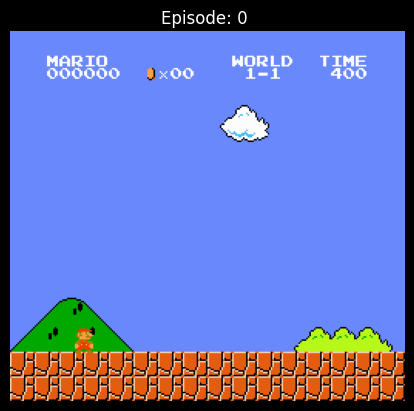

In [8]:
mario_utils.show_state(env)

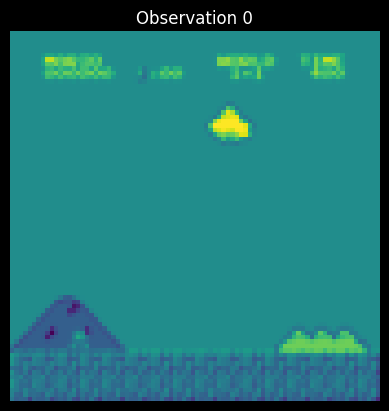

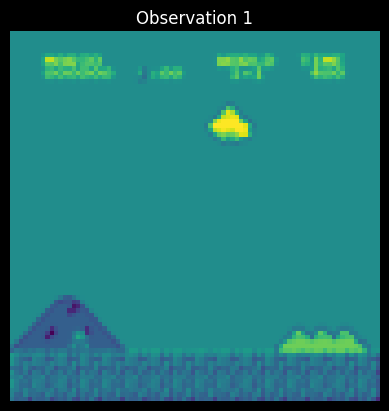

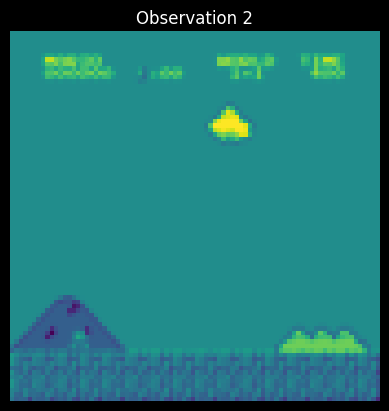

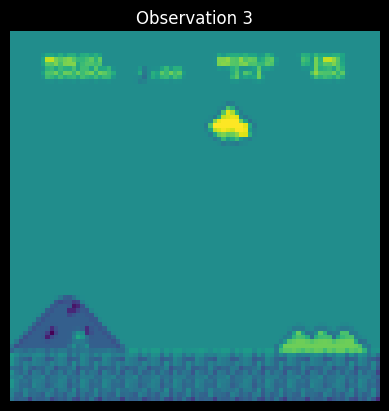

In [9]:
obs = env.reset()
mario_utils.show_obs(obs)

In [10]:
from IPython.display import HTML
from pyvirtualdisplay import Display

display = Display(visible=0, size=(1400, 900),color_depth=16)
display.start()

wrapped_env = mario_utils.wrap_env(env)
state = wrapped_env.reset()

while True:        
  wrapped_env.render()
  state, reward, done, info = wrapped_env.step(wrapped_env.action_space.sample())
  if done:
    break

wrapped_env.close()

In [11]:
mario_utils.show_video()

# Deep Q Learning


Recomendamos empezar implementando Deep Q Learning (paper presentado por DeepMind, pueden encontrar el mismo en arxiv: https://arxiv.org/pdf/1312.5602.pdf0).

***

En las celdas siguientes dejamos el código que deben implementar asi como una explicación del mismo.

# Memoria

El algoritmo de Deep Q Learning presentado en el paper utiliza una memoria (llamada Replay Memory) para almacenar transiciones pasadas. Tuplas que contienen un estado base, la accion tomada, la recompensa obtenida, una bandera que indica si el siguiente estado es final o no; y el estado siguiente.

Esta memoria es circular, es decir, tiene un límite maximo de elementos y una vez esté llena comienza a reemplazar los elementos más viejos.

Vamos a necesitar crear una función **sample** que obtiene una mustra aleatoria de elementos de la memoria.  Esto puede ser una lista de Transiciones o listas separadas (pero alineadas) de los elementos que las componen.

***

Para implementar esta funcionalidad se debe modificar el archivo **replay_memory.py**


In [12]:
from replay_memory import ReplayMemory

# Modelo

Vamos a usar un mismo modelo FeedForward para estos dos problemas (entrenado en cada problema particular). Recomendamos simplicidad en la creación del mismo, pero tienen total libertad al momento de implementarlo.

***
Para implementar esta funcionalidad se debe modificar el archivo **dqn_cnn_model.py**


In [13]:
from dqn_cnn_model import DQN_CNN_Model
from mario_utils import make_env

test_env = make_env(ENV_NAME)

test_net = DQN_CNN_Model(test_env.observation_space.shape, test_env.action_space.n).to(DEVICE)

from torchsummary import summary
summary(test_net, test_env.observation_space.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 20, 20]           8,224
            Conv2d-2             [-1, 64, 9, 9]          32,832
            Conv2d-3             [-1, 64, 7, 7]          36,928
            Linear-4                  [-1, 512]       1,606,144
            Linear-5                    [-1, 4]           2,052
Total params: 1,686,180
Trainable params: 1,686,180
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.17
Params size (MB): 6.43
Estimated Total Size (MB): 6.71
----------------------------------------------------------------


# Agente

Vamos a definir una clase agente, encargado de interactuar con el ambiente y entrenar los modelos. Los métdos definidos deben funcionar para ambos problemas simplemente cambiando el modelo a utilizar para cada ambiente.

Abajo dejamos un esqueleto del mismo y las funciones a completar. Recomendamos no alterar la estructura del mismo, pero pueden definir las funciones auxiliares que consideren necesarias.

Una aclaracion particular es sobre los últimos tres parametros del agente, representan los valores de epsilon_inicial, epsilon_final y el tiempo (numero de steps) que tardamos en llegar del epsilon final al inicial (puede decrementarlo de forma lineal o exponencial en el número de steps).

***

Para implementar esta funcionalidad se debe modificar los archivos **abstract_agent.py**, **dqn_agent.py** y **double_dqn_agent.py**.

Funciones a completar:


1. init: que inicializa los parametros del agente.

2. compute_epsilon: que computa el valor actual de epsilon en base al número de pasos actuales.

3. select_action: Seleccionando acciones "epsilongreedy-mente" si estamos entranando y completamente greedy en otro caso.

4. train: que entrena el agente por un número dado de episodios de largo determinado.

5. record_test_episode: para grabar un episodio con el agente siempre seleccionando la mejor accion conocida.

# Entrenamiento

Para entrenar van a necesitar definir:

1. El ambiente.
2. Una instancia del modelo a utilizar para el problema (ej: `mario_model = DQNModel(espacio_obs, num_acciones)`.
3. La función para procesar los estados (phi en el paper) que es necesaria para poder usar el modelo de Pytorch con las representaciones de gym.

Una vez definido pueden llamar a la función train del agente para entrenarlo y problar las demás funciones.

***

Una de las cosas que recomendamos hacer para probar los algoritmos es entrenar el agente por una cantidad X de episodios, grabar un video para observar progreso, volver a entrenar el mismo agente y volver a grabar un video, todas las veces que considere necesario.

***

In [14]:
%load_ext tensorboard

In [18]:
def process_state(obs):
    obs_array = np.array(obs)
    return torch.tensor(obs_array, dtype=torch.float32, device=DEVICE).unsqueeze(dim=0)
    # Transform the observation into a tensor
    # return torch.tensor(obs, dtype=torch.float32, device=DEVICE).unsqueeze(dim=0)

#Hiperparámetros de entrenamiento del agente DQN
TOTAL_STEPS =1000000
EPISODES = 10000
STEPS = 10000

EPSILON_INI = 1
EPSILON_MIN = 0.02
EPSILON_DECAY = 0.99998599985
EPSILON_TIME = None
EPISODE_BLOCK = 10

BATCH_SIZE = 32
BUFFER_SIZE = 10000

GAMMA = 0.99
LEARNING_RATE = 1e-4

In [16]:
torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

device(type='cuda', index=0)

In [20]:
from dqn_agent import DQNAgent

MODEL_NAME = "DQN_" + ENV_NAME + "_" + str(EPISODES)
MODEL_PATH = "models/" + MODEL_NAME + ".pt"
env = mario_utils.make_env(ENV_NAME)

# Cada vez que hacemos un experimento reseteamos la semilla para tener reproducibilidad
env.seed(42)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

net = DQN_CNN_Model(env.observation_space.shape, env.action_space.n).to(DEVICE)


#gym_env, model, obs_processing_func, memory_buffer_size, batch_size, learning_rate, gamma, epsilon_i, epsilon_f, epsilon_anneal_time
agent = DQNAgent(env, net, process_state, BUFFER_SIZE, BATCH_SIZE, LEARNING_RATE, GAMMA, epsilon_i= EPSILON_INI, epsilon_f=EPSILON_MIN, epsilon_anneal_time=EPSILON_TIME, epsilon_decay = EPSILON_DECAY, episode_block = EPISODE_BLOCK)

agent.train(EPISODES, STEPS, TOTAL_STEPS, writer_name = MODEL_NAME)
agent.save_model(MODEL_PATH)
# agent.load_model(MODEL_PATH)

  0%|          | 1/10000 [00:01<4:12:26,  1.51s/ episodes]

Episode 0 - Avg. Reward over the last 10 episodes 632.0 epsilon 0.9975250239196638 steps 178.0 total steps 178


  0%|          | 11/10000 [00:25<7:08:10,  2.57s/ episodes]

Episode 10 - Avg. Reward over the last 10 episodes 690.5 epsilon 0.9625005156807334 steps 255.3 total steps 2731


  0%|          | 21/10000 [00:48<7:21:51,  2.66s/ episodes]

Episode 20 - Avg. Reward over the last 10 episodes 579.5 epsilon 0.9287447743976287 steps 255.0 total steps 5281


  0%|          | 31/10000 [01:09<4:40:01,  1.69s/ episodes] 

Episode 30 - Avg. Reward over the last 10 episodes 584.5 epsilon 0.8994661332976728 steps 228.8 total steps 7569


  0%|          | 41/10000 [01:47<13:22:11,  4.83s/ episodes]

Episode 40 - Avg. Reward over the last 10 episodes 550.3 epsilon 0.8500153434265338 steps 403.9 total steps 11608


  1%|          | 51/10000 [02:26<9:51:18,  3.57s/ episodes] 

Episode 50 - Avg. Reward over the last 10 episodes 610.6 epsilon 0.7994350683568833 steps 438.2 total steps 15990


  1%|          | 61/10000 [02:53<5:43:51,  2.08s/ episodes] 

Episode 60 - Avg. Reward over the last 10 episodes 723.2 epsilon 0.7683801608746966 steps 283.0 total steps 18820


  1%|          | 71/10000 [03:09<4:24:43,  1.60s/ episodes]

Episode 70 - Avg. Reward over the last 10 episodes 628.7 epsilon 0.7490488191124645 steps 182.0 total steps 20640


  1%|          | 81/10000 [03:33<4:36:31,  1.67s/ episodes]

Episode 80 - Avg. Reward over the last 10 episodes 503.6 epsilon 0.7227284232745075 steps 255.5 total steps 23195


  1%|          | 91/10000 [03:47<1:50:41,  1.49 episodes/s]

Episode 90 - Avg. Reward over the last 10 episodes 420.4 epsilon 0.7083732693873216 steps 143.3 total steps 24628


  1%|          | 101/10000 [04:06<4:07:02,  1.50s/ episodes]

Episode 100 - Avg. Reward over the last 10 episodes 594.1 epsilon 0.6873878154525053 steps 214.8 total steps 26776


  1%|          | 111/10000 [04:21<3:42:10,  1.35s/ episodes]

Episode 110 - Avg. Reward over the last 10 episodes 527.4 epsilon 0.6725000937125678 steps 156.4 total steps 28340


  1%|          | 121/10000 [04:51<7:07:24,  2.60s/ episodes]

Episode 120 - Avg. Reward over the last 10 episodes 825.7 epsilon 0.6425415240649036 steps 325.5 total steps 31595


  1%|▏         | 131/10000 [05:06<2:42:12,  1.01 episodes/s]

Episode 130 - Avg. Reward over the last 10 episodes 608.4 epsilon 0.6281148559055784 steps 162.2 total steps 33217


  1%|▏         | 141/10000 [05:29<7:20:55,  2.68s/ episodes]

Episode 140 - Avg. Reward over the last 10 episodes 627.1 epsilon 0.6060863143862757 steps 255.0 total steps 35767


  2%|▏         | 151/10000 [05:58<6:55:06,  2.53s/ episodes] 

Episode 150 - Avg. Reward over the last 10 episodes 545.7 epsilon 0.5800194457757318 steps 314.0 total steps 38907


  2%|▏         | 161/10000 [06:11<3:53:45,  1.43s/ episodes]

Episode 160 - Avg. Reward over the last 10 episodes 442.7 epsilon 0.5679578782299798 steps 150.1 total steps 40408


  2%|▏         | 171/10000 [06:25<3:13:40,  1.18s/ episodes]

Episode 170 - Avg. Reward over the last 10 episodes 525.0 epsilon 0.5557657394388749 steps 155.0 total steps 41958


  2%|▏         | 181/10000 [06:47<5:04:07,  1.86s/ episodes]

Episode 180 - Avg. Reward over the last 10 episodes 654.8 epsilon 0.5378836614854562 steps 233.6 total steps 44294


  2%|▏         | 191/10000 [07:06<3:54:47,  1.44s/ episodes]

Episode 190 - Avg. Reward over the last 10 episodes 644.6 epsilon 0.5224607068633276 steps 207.8 total steps 46372


  2%|▏         | 201/10000 [07:32<4:39:56,  1.71s/ episodes]

Episode 200 - Avg. Reward over the last 10 episodes 651.8 epsilon 0.5026012400433575 steps 276.8 total steps 49140


  2%|▏         | 211/10000 [07:50<5:32:32,  2.04s/ episodes]

Episode 210 - Avg. Reward over the last 10 episodes 615.7 epsilon 0.48883968861083105 steps 198.3 total steps 51123


  2%|▏         | 221/10000 [08:04<4:56:10,  1.82s/ episodes]

Episode 220 - Avg. Reward over the last 10 episodes 462.1 epsilon 0.4791770948449446 steps 142.6 total steps 52549


  2%|▏         | 231/10000 [08:26<8:05:17,  2.98s/ episodes]

Episode 230 - Avg. Reward over the last 10 episodes 652.8 epsilon 0.46357104858732767 steps 236.5 total steps 54914


  2%|▏         | 241/10000 [08:41<5:04:34,  1.87s/ episodes]

Episode 240 - Avg. Reward over the last 10 episodes 570.2 epsilon 0.4529851081897013 steps 165.0 total steps 56564


  3%|▎         | 251/10000 [08:56<3:27:19,  1.28s/ episodes]

Episode 250 - Avg. Reward over the last 10 episodes 532.5 epsilon 0.4425107848866935 steps 167.1 total steps 58235


  3%|▎         | 261/10000 [09:11<4:48:38,  1.78s/ episodes]

Episode 260 - Avg. Reward over the last 10 episodes 540.6 epsilon 0.4323089192752253 steps 166.6 total steps 59901


  3%|▎         | 271/10000 [09:28<4:09:18,  1.54s/ episodes]

Episode 270 - Avg. Reward over the last 10 episodes 565.8 epsilon 0.42134415435682687 steps 183.5 total steps 61736


  3%|▎         | 281/10000 [09:44<6:04:15,  2.25s/ episodes]

Episode 280 - Avg. Reward over the last 10 episodes 562.3 epsilon 0.41141710182143 steps 170.3 total steps 63439


  3%|▎         | 291/10000 [09:52<1:40:06,  1.62 episodes/s]

Episode 290 - Avg. Reward over the last 10 episodes 361.6 epsilon 0.40611213509001726 steps 92.7 total steps 64366


  3%|▎         | 301/10000 [10:06<3:37:42,  1.35s/ episodes]

Episode 300 - Avg. Reward over the last 10 episodes 515.4 epsilon 0.397817338209866 steps 147.4 total steps 65840


  3%|▎         | 311/10000 [10:42<18:56:54,  7.04s/ episodes]

Episode 310 - Avg. Reward over the last 10 episodes 712.1 epsilon 0.376931696788373 steps 385.2 total steps 69692


  3%|▎         | 321/10000 [11:05<3:35:55,  1.34s/ episodes] 

Episode 320 - Avg. Reward over the last 10 episodes 482.7 epsilon 0.36378875898449337 steps 253.5 total steps 72227


  3%|▎         | 331/10000 [11:16<2:17:46,  1.17 episodes/s]

Episode 330 - Avg. Reward over the last 10 episodes 537.4 epsilon 0.3579534966276189 steps 115.5 total steps 73382


  3%|▎         | 341/10000 [11:30<3:16:06,  1.22s/ episodes]

Episode 340 - Avg. Reward over the last 10 episodes 720.7 epsilon 0.3502939632995362 steps 154.5 total steps 74927


  4%|▎         | 351/10000 [11:48<5:27:47,  2.04s/ episodes]

Episode 350 - Avg. Reward over the last 10 episodes 747.7 epsilon 0.3408458126670458 steps 195.3 total steps 76880


  4%|▎         | 361/10000 [11:57<3:31:57,  1.32s/ episodes]

Episode 360 - Avg. Reward over the last 10 episodes 409.3 epsilon 0.336215381329429 steps 97.7 total steps 77857


  4%|▎         | 371/10000 [12:03<1:50:19,  1.45 episodes/s]

Episode 370 - Avg. Reward over the last 10 episodes 312.4 epsilon 0.33303440470222373 steps 67.9 total steps 78536


  4%|▍         | 381/10000 [12:20<5:38:04,  2.11s/ episodes]

Episode 380 - Avg. Reward over the last 10 episodes 658.3 epsilon 0.3245784769438754 steps 183.7 total steps 80373


  4%|▍         | 391/10000 [12:30<1:46:07,  1.51 episodes/s]

Episode 390 - Avg. Reward over the last 10 episodes 430.3 epsilon 0.3196360723417162 steps 109.6 total steps 81469


  4%|▍         | 401/10000 [12:40<2:10:38,  1.22 episodes/s]

Episode 400 - Avg. Reward over the last 10 episodes 387.2 epsilon 0.31474248651968156 steps 110.2 total steps 82571


  4%|▍         | 411/10000 [12:53<3:11:03,  1.20s/ episodes]

Episode 410 - Avg. Reward over the last 10 episodes 524.0 epsilon 0.3087501768907458 steps 137.3 total steps 83944


  4%|▍         | 421/10000 [13:03<2:34:44,  1.03 episodes/s]

Episode 420 - Avg. Reward over the last 10 episodes 350.3 epsilon 0.3043043049727443 steps 103.6 total steps 84980


  4%|▍         | 431/10000 [13:12<2:15:58,  1.17 episodes/s]

Episode 430 - Avg. Reward over the last 10 episodes 404.1 epsilon 0.30004424712505706 steps 100.7 total steps 85987


  4%|▍         | 441/10000 [13:30<4:46:13,  1.80s/ episodes]

Episode 440 - Avg. Reward over the last 10 episodes 572.5 epsilon 0.29215996642764314 steps 190.2 total steps 87889


  5%|▍         | 451/10000 [13:54<9:39:35,  3.64s/ episodes]

Episode 450 - Avg. Reward over the last 10 episodes 721.4 epsilon 0.2819531303150805 steps 254.0 total steps 90429


  5%|▍         | 461/10000 [14:14<5:21:34,  2.02s/ episodes]

Episode 460 - Avg. Reward over the last 10 episodes 634.7 epsilon 0.27346627660708667 steps 218.3 total steps 92612


  5%|▍         | 471/10000 [14:26<2:22:45,  1.11 episodes/s]

Episode 470 - Avg. Reward over the last 10 episodes 436.2 epsilon 0.2687974188563525 steps 123.0 total steps 93842


  5%|▍         | 481/10000 [14:40<3:36:30,  1.36s/ episodes]

Episode 480 - Avg. Reward over the last 10 episodes 550.2 epsilon 0.2630161983552025 steps 155.3 total steps 95395


  5%|▍         | 491/10000 [14:53<2:58:56,  1.13s/ episodes]

Episode 490 - Avg. Reward over the last 10 episodes 541.7 epsilon 0.2579653510123904 steps 138.5 total steps 96780


  5%|▌         | 501/10000 [15:08<4:32:22,  1.72s/ episodes]

Episode 500 - Avg. Reward over the last 10 episodes 559.9 epsilon 0.25201808840698864 steps 166.6 total steps 98446


  5%|▌         | 511/10000 [15:20<4:57:05,  1.88s/ episodes]

Episode 510 - Avg. Reward over the last 10 episodes 464.1 epsilon 0.2472857445562768 steps 135.4 total steps 99800


  5%|▌         | 521/10000 [15:37<5:21:50,  2.04s/ episodes]

Episode 520 - Avg. Reward over the last 10 episodes 640.0 epsilon 0.2411183956547298 steps 180.4 total steps 101604


  5%|▌         | 531/10000 [15:57<6:02:37,  2.30s/ episodes]

Episode 530 - Avg. Reward over the last 10 episodes 671.7 epsilon 0.23373302146156197 steps 222.2 total steps 103826


  5%|▌         | 541/10000 [16:12<4:48:11,  1.83s/ episodes]

Episode 540 - Avg. Reward over the last 10 episodes 517.1 epsilon 0.22849472587438105 steps 161.9 total steps 105445


  6%|▌         | 551/10000 [16:30<3:30:09,  1.33s/ episodes]

Episode 550 - Avg. Reward over the last 10 episodes 618.5 epsilon 0.222372220650874 steps 194.0 total steps 107385


  6%|▌         | 561/10000 [16:49<4:54:47,  1.87s/ episodes]

Episode 560 - Avg. Reward over the last 10 episodes 560.4 epsilon 0.21602931904825975 steps 206.7 total steps 109452


  6%|▌         | 571/10000 [16:56<1:30:18,  1.74 episodes/s]

Episode 570 - Avg. Reward over the last 10 episodes 299.1 epsilon 0.2140004178635478 steps 67.4 total steps 110126


  6%|▌         | 581/10000 [17:12<5:02:12,  1.93s/ episodes]

Episode 580 - Avg. Reward over the last 10 episodes 508.3 epsilon 0.20890289788710084 steps 172.2 total steps 111848


  6%|▌         | 591/10000 [17:32<7:11:54,  2.75s/ episodes]

Episode 590 - Avg. Reward over the last 10 episodes 635.3 epsilon 0.20254396882992695 steps 220.8 total steps 114056


  6%|▌         | 601/10000 [17:49<5:02:33,  1.93s/ episodes]

Episode 600 - Avg. Reward over the last 10 episodes 559.8 epsilon 0.19751737355438573 steps 179.5 total steps 115851


  6%|▌         | 611/10000 [18:05<3:22:05,  1.29s/ episodes]

Episode 610 - Avg. Reward over the last 10 episodes 607.0 epsilon 0.19263170549286168 steps 178.9 total steps 117640


  6%|▌         | 621/10000 [18:24<3:59:40,  1.53s/ episodes]

Episode 620 - Avg. Reward over the last 10 episodes 601.7 epsilon 0.18721573200053054 steps 203.7 total steps 119677


  6%|▋         | 631/10000 [18:43<4:59:30,  1.92s/ episodes]

Episode 630 - Avg. Reward over the last 10 episodes 628.8 epsilon 0.18205140704174658 steps 199.8 total steps 121675


  6%|▋         | 641/10000 [19:04<7:03:24,  2.71s/ episodes]

Episode 640 - Avg. Reward over the last 10 episodes 623.9 epsilon 0.1761222783122586 steps 236.5 total steps 124040


  7%|▋         | 651/10000 [19:18<4:09:06,  1.60s/ episodes]

Episode 650 - Avg. Reward over the last 10 episodes 587.9 epsilon 0.17240185856919363 steps 152.5 total steps 125565


  7%|▋         | 661/10000 [19:36<4:15:25,  1.64s/ episodes]

Episode 660 - Avg. Reward over the last 10 episodes 567.1 epsilon 0.1678199471594619 steps 192.4 total steps 127489


  7%|▋         | 671/10000 [19:55<4:20:39,  1.68s/ episodes]

Episode 670 - Avg. Reward over the last 10 episodes 524.6 epsilon 0.16298744022364203 steps 208.7 total steps 129576


  7%|▋         | 681/10000 [20:13<3:54:17,  1.51s/ episodes]

Episode 680 - Avg. Reward over the last 10 episodes 603.6 epsilon 0.1585891125149118 steps 195.4 total steps 131530


  7%|▋         | 691/10000 [20:26<5:24:54,  2.09s/ episodes]

Episode 690 - Avg. Reward over the last 10 episodes 364.4 epsilon 0.1555392817413477 steps 138.7 total steps 132917


  7%|▋         | 701/10000 [20:47<6:29:38,  2.51s/ episodes]

Episode 700 - Avg. Reward over the last 10 episodes 772.3 epsilon 0.15050100051609056 steps 235.2 total steps 135269


  7%|▋         | 711/10000 [21:00<2:05:58,  1.23 episodes/s]

Episode 710 - Avg. Reward over the last 10 episodes 502.8 epsilon 0.14767699117052274 steps 135.3 total steps 136622


  7%|▋         | 721/10000 [21:30<7:55:19,  3.07s/ episodes]

Episode 720 - Avg. Reward over the last 10 episodes 679.4 epsilon 0.1411397585028777 steps 323.4 total steps 139856


  7%|▋         | 731/10000 [21:39<3:25:52,  1.33s/ episodes]

Episode 730 - Avg. Reward over the last 10 episodes 413.9 epsilon 0.13905288531318463 steps 106.4 total steps 140920


  7%|▋         | 741/10000 [22:00<5:33:42,  2.16s/ episodes]

Episode 740 - Avg. Reward over the last 10 episodes 713.0 epsilon 0.1343679219370943 steps 244.8 total steps 143368


  8%|▊         | 751/10000 [22:09<2:24:25,  1.07 episodes/s]

Episode 750 - Avg. Reward over the last 10 episodes 400.9 epsilon 0.13229780084590023 steps 110.9 total steps 144477


  8%|▊         | 761/10000 [22:28<5:41:11,  2.22s/ episodes]

Episode 760 - Avg. Reward over the last 10 episodes 609.6 epsilon 0.12822581569782662 steps 223.3 total steps 146710


  8%|▊         | 771/10000 [22:47<3:46:49,  1.47s/ episodes]

Episode 770 - Avg. Reward over the last 10 episodes 757.8 epsilon 0.12418871800136366 steps 228.5 total steps 148995


  8%|▊         | 781/10000 [23:03<4:41:40,  1.83s/ episodes]

Episode 780 - Avg. Reward over the last 10 episodes 662.0 epsilon 0.1209914480705054 steps 186.3 total steps 150858


  8%|▊         | 791/10000 [23:15<3:14:15,  1.27s/ episodes]

Episode 790 - Avg. Reward over the last 10 episodes 554.5 epsilon 0.1186314367820094 steps 140.7 total steps 152265


  8%|▊         | 801/10000 [23:32<3:10:42,  1.24s/ episodes]

Episode 800 - Avg. Reward over the last 10 episodes 689.4 epsilon 0.11537838419435659 steps 198.6 total steps 154251


  8%|▊         | 811/10000 [23:42<3:08:12,  1.23s/ episodes]

Episode 810 - Avg. Reward over the last 10 episodes 419.8 epsilon 0.11339266617201978 steps 124.0 total steps 155491


  8%|▊         | 821/10000 [23:56<4:10:00,  1.63s/ episodes]

Episode 820 - Avg. Reward over the last 10 episodes 527.2 epsilon 0.11084982033122281 steps 162.0 total steps 157111


  8%|▊         | 831/10000 [24:06<2:26:37,  1.04 episodes/s]

Episode 830 - Avg. Reward over the last 10 episodes 431.2 epsilon 0.1091404996649823 steps 111.0 total steps 158221


  8%|▊         | 841/10000 [24:21<2:56:57,  1.16s/ episodes]

Episode 840 - Avg. Reward over the last 10 episodes 606.1 epsilon 0.10674081925561578 steps 158.8 total steps 159809


  9%|▊         | 851/10000 [24:36<2:55:56,  1.15s/ episodes]

Episode 850 - Avg. Reward over the last 10 episodes 563.4 epsilon 0.10434860287565202 steps 161.9 total steps 161428


  9%|▊         | 861/10000 [25:01<5:52:51,  2.32s/ episodes]

Episode 860 - Avg. Reward over the last 10 episodes 798.8 epsilon 0.10040887129277705 steps 274.9 total steps 164177


  9%|▊         | 871/10000 [25:17<3:36:57,  1.43s/ episodes]

Episode 870 - Avg. Reward over the last 10 episodes 565.5 epsilon 0.0980816355222611 steps 167.5 total steps 165852


  9%|▉         | 881/10000 [25:36<4:44:26,  1.87s/ episodes]

Episode 880 - Avg. Reward over the last 10 episodes 650.3 epsilon 0.09528664222563453 steps 206.5 total steps 167917


  9%|▉         | 891/10000 [25:54<4:59:25,  1.97s/ episodes]

Episode 890 - Avg. Reward over the last 10 episodes 613.0 epsilon 0.09257000072755539 steps 206.6 total steps 169983


  9%|▉         | 901/10000 [26:14<4:33:38,  1.80s/ episodes]

Episode 900 - Avg. Reward over the last 10 episodes 682.2 epsilon 0.08982008273149875 steps 215.4 total steps 172137


  9%|▉         | 911/10000 [26:34<3:27:11,  1.37s/ episodes]

Episode 910 - Avg. Reward over the last 10 episodes 709.6 epsilon 0.0872837304095737 steps 204.6 total steps 174183


  9%|▉         | 921/10000 [26:54<4:41:22,  1.86s/ episodes]

Episode 920 - Avg. Reward over the last 10 episodes 629.0 epsilon 0.08468729127179205 steps 215.7 total steps 176340


  9%|▉         | 931/10000 [27:10<3:33:46,  1.41s/ episodes]

Episode 930 - Avg. Reward over the last 10 episodes 615.6 epsilon 0.08267813031587436 steps 171.5 total steps 178055


  9%|▉         | 941/10000 [27:32<5:06:17,  2.03s/ episodes]

Episode 940 - Avg. Reward over the last 10 episodes 667.7 epsilon 0.0799372957222408 steps 240.8 total steps 180463


 10%|▉         | 951/10000 [27:42<2:03:37,  1.22 episodes/s]

Episode 950 - Avg. Reward over the last 10 episodes 405.5 epsilon 0.0787024470307516 steps 111.2 total steps 181575


 10%|▉         | 961/10000 [27:52<1:53:24,  1.33 episodes/s]

Episode 960 - Avg. Reward over the last 10 episodes 450.4 epsilon 0.07746606485270419 steps 113.1 total steps 182706


 10%|▉         | 971/10000 [28:05<2:36:20,  1.04s/ episodes]

Episode 970 - Avg. Reward over the last 10 episodes 511.5 epsilon 0.0760433550820357 steps 132.4 total steps 184030


 10%|▉         | 981/10000 [28:17<3:25:04,  1.36s/ episodes]

Episode 980 - Avg. Reward over the last 10 episodes 516.1 epsilon 0.07457678712684923 steps 139.1 total steps 185421


 10%|▉         | 991/10000 [28:26<2:30:11,  1.00s/ episodes]

Episode 990 - Avg. Reward over the last 10 episodes 396.9 epsilon 0.07353379119934224 steps 100.6 total steps 186427


 10%|█         | 1001/10000 [28:35<2:50:58,  1.14s/ episodes]

Episode 1000 - Avg. Reward over the last 10 episodes 342.6 epsilon 0.07249827681799544 steps 101.3 total steps 187440


 10%|█         | 1011/10000 [28:52<6:25:20,  2.57s/ episodes]

Episode 1010 - Avg. Reward over the last 10 episodes 573.4 epsilon 0.07069807523528886 steps 179.6 total steps 189236


 10%|█         | 1021/10000 [29:03<2:27:15,  1.02 episodes/s]

Episode 1020 - Avg. Reward over the last 10 episodes 459.1 epsilon 0.06951246218770332 steps 120.8 total steps 190444


 10%|█         | 1031/10000 [29:14<2:57:34,  1.19s/ episodes]

Episode 1030 - Avg. Reward over the last 10 episodes 409.4 epsilon 0.06832855384209395 steps 122.7 total steps 191671


 10%|█         | 1041/10000 [29:31<4:25:43,  1.78s/ episodes]

Episode 1040 - Avg. Reward over the last 10 episodes 607.0 epsilon 0.0665740780598283 steps 185.8 total steps 193529


 11%|█         | 1051/10000 [29:46<3:56:25,  1.59s/ episodes]

Episode 1050 - Avg. Reward over the last 10 episodes 556.3 epsilon 0.06501739596600557 steps 169.0 total steps 195219


 11%|█         | 1061/10000 [29:55<2:33:08,  1.03s/ episodes]

Episode 1060 - Avg. Reward over the last 10 episodes 422.6 epsilon 0.06415298536558926 steps 95.6 total steps 196175


 11%|█         | 1071/10000 [30:12<5:04:22,  2.05s/ episodes]

Episode 1070 - Avg. Reward over the last 10 episodes 640.7 epsilon 0.0625241055799742 steps 183.7 total steps 198012


 11%|█         | 1081/10000 [30:28<2:58:23,  1.20s/ episodes]

Episode 1080 - Avg. Reward over the last 10 episodes 581.6 epsilon 0.06105613890109656 steps 169.7 total steps 199709


 11%|█         | 1091/10000 [30:41<3:12:52,  1.30s/ episodes]

Episode 1090 - Avg. Reward over the last 10 episodes 579.4 epsilon 0.059868554630904194 steps 140.3 total steps 201112


 11%|█         | 1101/10000 [30:56<3:35:38,  1.45s/ episodes]

Episode 1100 - Avg. Reward over the last 10 episodes 620.0 epsilon 0.05841957189331679 steps 175.0 total steps 202862


 11%|█         | 1111/10000 [31:02<2:11:22,  1.13 episodes/s]

Episode 1110 - Avg. Reward over the last 10 episodes 379.3 epsilon 0.05775678124857906 steps 81.5 total steps 203677


 11%|█         | 1121/10000 [31:15<2:09:51,  1.14 episodes/s]

Episode 1120 - Avg. Reward over the last 10 episodes 557.9 epsilon 0.05650981727225111 steps 155.9 total steps 205236


 11%|█▏        | 1131/10000 [31:26<2:06:51,  1.17 episodes/s]

Episode 1130 - Avg. Reward over the last 10 episodes 495.1 epsilon 0.055579258659089054 steps 118.6 total steps 206422


 11%|█▏        | 1141/10000 [31:38<2:05:57,  1.17 episodes/s]

Episode 1140 - Avg. Reward over the last 10 episodes 515.3 epsilon 0.05454858401486606 steps 133.7 total steps 207759


 12%|█▏        | 1151/10000 [31:51<3:35:13,  1.46s/ episodes]

Episode 1150 - Avg. Reward over the last 10 episodes 471.5 epsilon 0.05350105700950053 steps 138.5 total steps 209144


 12%|█▏        | 1161/10000 [32:05<3:18:42,  1.35s/ episodes]

Episode 1160 - Avg. Reward over the last 10 episodes 563.6 epsilon 0.05240316779492245 steps 148.1 total steps 210625


 12%|█▏        | 1171/10000 [32:27<4:12:53,  1.72s/ episodes]

Episode 1170 - Avg. Reward over the last 10 episodes 676.1 epsilon 0.05067802834173242 steps 239.1 total steps 213016


 12%|█▏        | 1181/10000 [32:42<2:12:54,  1.11 episodes/s]

Episode 1180 - Avg. Reward over the last 10 episodes 536.2 epsilon 0.04950897851189254 steps 166.7 total steps 214683


 12%|█▏        | 1191/10000 [32:56<3:52:51,  1.59s/ episodes]

Episode 1190 - Avg. Reward over the last 10 episodes 574.3 epsilon 0.0485133819971802 steps 145.1 total steps 216134


 12%|█▏        | 1201/10000 [33:07<2:42:19,  1.11s/ episodes]

Episode 1200 - Avg. Reward over the last 10 episodes 486.2 epsilon 0.04764908173696865 steps 128.4 total steps 217418


 12%|█▏        | 1211/10000 [33:30<5:52:03,  2.40s/ episodes]

Episode 1210 - Avg. Reward over the last 10 episodes 576.5 epsilon 0.046040468077800226 steps 245.3 total steps 219871


 12%|█▏        | 1221/10000 [33:44<3:27:15,  1.42s/ episodes]

Episode 1220 - Avg. Reward over the last 10 episodes 529.0 epsilon 0.04507421596108062 steps 151.5 total steps 221386


 12%|█▏        | 1231/10000 [34:01<2:47:37,  1.15s/ episodes]

Episode 1230 - Avg. Reward over the last 10 episodes 594.9 epsilon 0.043910080212664 steps 186.9 total steps 223255


 12%|█▏        | 1241/10000 [34:14<5:26:50,  2.24s/ episodes]

Episode 1240 - Avg. Reward over the last 10 episodes 500.9 epsilon 0.04303852118519974 steps 143.2 total steps 224687


 13%|█▎        | 1251/10000 [34:38<5:25:40,  2.23s/ episodes]

Episode 1250 - Avg. Reward over the last 10 episodes 777.7 epsilon 0.041542497087311454 steps 252.7 total steps 227214


 13%|█▎        | 1261/10000 [34:48<2:43:36,  1.12s/ episodes]

Episode 1260 - Avg. Reward over the last 10 episodes 447.9 epsilon 0.04093455894839092 steps 105.3 total steps 228267


 13%|█▎        | 1271/10000 [35:07<5:41:43,  2.35s/ episodes]

Episode 1270 - Avg. Reward over the last 10 episodes 689.5 epsilon 0.03971909817578933 steps 215.3 total steps 230420


 13%|█▎        | 1281/10000 [35:30<5:25:45,  2.24s/ episodes]

Episode 1280 - Avg. Reward over the last 10 episodes 797.6 epsilon 0.038402921500389854 steps 240.7 total steps 232827


 13%|█▎        | 1291/10000 [35:44<4:18:37,  1.78s/ episodes]

Episode 1290 - Avg. Reward over the last 10 episodes 601.2 epsilon 0.03756170867174292 steps 158.2 total steps 234409


 13%|█▎        | 1301/10000 [35:58<2:51:10,  1.18s/ episodes]

Episode 1300 - Avg. Reward over the last 10 episodes 590.6 epsilon 0.03676773766049786 steps 152.6 total steps 235935


 13%|█▎        | 1311/10000 [36:24<4:49:45,  2.00s/ episodes]

Episode 1310 - Avg. Reward over the last 10 episodes 688.3 epsilon 0.035359251682398084 steps 279.0 total steps 238725


 13%|█▎        | 1321/10000 [36:40<4:31:07,  1.87s/ episodes]

Episode 1320 - Avg. Reward over the last 10 episodes 634.5 epsilon 0.03453487409568409 steps 168.5 total steps 240410


 13%|█▎        | 1331/10000 [36:54<2:24:46,  1.00s/ episodes]

Episode 1330 - Avg. Reward over the last 10 episodes 485.8 epsilon 0.03378643088260463 steps 156.5 total steps 241975


 13%|█▎        | 1341/10000 [37:15<4:45:13,  1.98s/ episodes]

Episode 1340 - Avg. Reward over the last 10 episodes 759.4 epsilon 0.03274697905283215 steps 223.2 total steps 244207


 14%|█▎        | 1351/10000 [37:31<3:43:03,  1.55s/ episodes]

Episode 1350 - Avg. Reward over the last 10 episodes 623.9 epsilon 0.03196201880046752 steps 173.3 total steps 245940


 14%|█▎        | 1361/10000 [37:39<1:15:19,  1.91 episodes/s]

Episode 1360 - Avg. Reward over the last 10 episodes 353.4 epsilon 0.03156844563638321 steps 88.5 total steps 246825


 14%|█▎        | 1371/10000 [37:51<1:54:32,  1.26 episodes/s]

Episode 1370 - Avg. Reward over the last 10 episodes 497.9 epsilon 0.030993445302251055 steps 131.3 total steps 248138


 14%|█▍        | 1381/10000 [37:59<2:07:08,  1.13 episodes/s]

Episode 1380 - Avg. Reward over the last 10 episodes 375.0 epsilon 0.030606227996872494 steps 89.8 total steps 249036


 14%|█▍        | 1391/10000 [38:11<3:50:25,  1.61s/ episodes]

Episode 1390 - Avg. Reward over the last 10 episodes 466.7 epsilon 0.030044126647110467 steps 132.4 total steps 250360


 14%|█▍        | 1401/10000 [38:18<2:38:23,  1.11s/ episodes]

Episode 1400 - Avg. Reward over the last 10 episodes 445.3 epsilon 0.029690792462341804 steps 84.5 total steps 251205


 14%|█▍        | 1411/10000 [38:28<1:17:04,  1.86 episodes/s]

Episode 1410 - Avg. Reward over the last 10 episodes 395.1 epsilon 0.029264486717175655 steps 103.3 total steps 252238


 14%|█▍        | 1421/10000 [38:34<1:20:05,  1.79 episodes/s]

Episode 1420 - Avg. Reward over the last 10 episodes 348.0 epsilon 0.02895759552754587 steps 75.3 total steps 252991


 14%|█▍        | 1431/10000 [38:39<1:21:36,  1.75 episodes/s]

Episode 1430 - Avg. Reward over the last 10 episodes 264.8 epsilon 0.02875237609817363 steps 50.8 total steps 253499


 14%|█▍        | 1441/10000 [38:53<4:11:00,  1.76s/ episodes]

Episode 1440 - Avg. Reward over the last 10 episodes 573.8 epsilon 0.028143432722012036 steps 152.9 total steps 255028


 15%|█▍        | 1451/10000 [39:11<2:00:49,  1.18 episodes/s]

Episode 1450 - Avg. Reward over the last 10 episodes 599.5 epsilon 0.027393165634374904 steps 193.0 total steps 256958


 15%|█▍        | 1461/10000 [39:18<1:31:42,  1.55 episodes/s]

Episode 1460 - Avg. Reward over the last 10 episodes 325.9 epsilon 0.027104001258250503 steps 75.8 total steps 257716


 15%|█▍        | 1471/10000 [39:36<4:33:39,  1.93s/ episodes]

Episode 1470 - Avg. Reward over the last 10 episodes 722.1 epsilon 0.026356709422907992 steps 199.7 total steps 259713


 15%|█▍        | 1481/10000 [39:48<1:57:38,  1.21 episodes/s]

Episode 1480 - Avg. Reward over the last 10 episodes 525.8 epsilon 0.025891857950033834 steps 127.1 total steps 260984


 15%|█▍        | 1491/10000 [40:04<3:10:50,  1.35s/ episodes]

Episode 1490 - Avg. Reward over the last 10 episodes 548.4 epsilon 0.025282188408347336 steps 170.2 total steps 262686


 15%|█▌        | 1501/10000 [40:27<6:34:19,  2.78s/ episodes]

Episode 1500 - Avg. Reward over the last 10 episodes 554.8 epsilon 0.0243678704519954 steps 263.1 total steps 265317


 15%|█▌        | 1511/10000 [40:40<3:08:04,  1.33s/ episodes]

Episode 1510 - Avg. Reward over the last 10 episodes 533.8 epsilon 0.02382308525590381 steps 161.5 total steps 266932


 15%|█▌        | 1521/10000 [40:59<6:01:05,  2.56s/ episodes]

Episode 1520 - Avg. Reward over the last 10 episodes 708.1 epsilon 0.02308434128657611 steps 225.0 total steps 269182


 15%|█▌        | 1531/10000 [41:14<3:40:59,  1.57s/ episodes]

Episode 1530 - Avg. Reward over the last 10 episodes 416.2 epsilon 0.022531314377823092 steps 173.2 total steps 270914


 15%|█▌        | 1541/10000 [41:27<3:30:23,  1.49s/ episodes]

Episode 1540 - Avg. Reward over the last 10 episodes 470.3 epsilon 0.02203499116137973 steps 159.1 total steps 272505


 16%|█▌        | 1551/10000 [41:42<2:57:08,  1.26s/ episodes]

Episode 1550 - Avg. Reward over the last 10 episodes 542.2 epsilon 0.021497771099036625 steps 176.3 total steps 274268


 16%|█▌        | 1561/10000 [41:47<55:01,  2.56 episodes/s]  

Episode 1560 - Avg. Reward over the last 10 episodes 262.9 epsilon 0.021321524750565635 steps 58.8 total steps 274856


 16%|█▌        | 1571/10000 [42:05<3:03:04,  1.30s/ episodes]

Episode 1570 - Avg. Reward over the last 10 episodes 502.8 epsilon 0.020695671794826564 steps 212.8 total steps 276984


 16%|█▌        | 1581/10000 [42:10<1:05:08,  2.15 episodes/s]

Episode 1580 - Avg. Reward over the last 10 episodes 263.8 epsilon 0.02054123755562588 steps 53.5 total steps 277519


 16%|█▌        | 1591/10000 [42:21<1:58:40,  1.18 episodes/s]

Episode 1590 - Avg. Reward over the last 10 episodes 496.9 epsilon 0.020184038987514155 steps 125.3 total steps 278772


 16%|█▌        | 1601/10000 [42:33<1:45:22,  1.33 episodes/s]

Episode 1600 - Avg. Reward over the last 10 episodes 366.6 epsilon 0.02 steps 147.6 total steps 280248


 16%|█▌        | 1611/10000 [42:47<1:43:49,  1.35 episodes/s]

Episode 1610 - Avg. Reward over the last 10 episodes 444.8 epsilon 0.02 steps 165.8 total steps 281906


 16%|█▌        | 1621/10000 [42:54<1:47:23,  1.30 episodes/s]

Episode 1620 - Avg. Reward over the last 10 episodes 350.0 epsilon 0.02 steps 88.4 total steps 282790


 16%|█▋        | 1631/10000 [43:10<2:21:36,  1.02s/ episodes]

Episode 1630 - Avg. Reward over the last 10 episodes 613.8 epsilon 0.02 steps 187.6 total steps 284666


 16%|█▋        | 1641/10000 [43:25<2:20:31,  1.01s/ episodes]

Episode 1640 - Avg. Reward over the last 10 episodes 523.2 epsilon 0.02 steps 187.1 total steps 286537


 17%|█▋        | 1651/10000 [43:58<8:44:13,  3.77s/ episodes]

Episode 1650 - Avg. Reward over the last 10 episodes 878.0 epsilon 0.02 steps 385.2 total steps 290389


 17%|█▋        | 1661/10000 [44:14<3:21:12,  1.45s/ episodes]

Episode 1660 - Avg. Reward over the last 10 episodes 602.9 epsilon 0.02 steps 192.1 total steps 292310


 17%|█▋        | 1671/10000 [44:31<3:59:21,  1.72s/ episodes]

Episode 1670 - Avg. Reward over the last 10 episodes 553.1 epsilon 0.02 steps 197.7 total steps 294287


 17%|█▋        | 1681/10000 [44:51<4:29:46,  1.95s/ episodes]

Episode 1680 - Avg. Reward over the last 10 episodes 606.4 epsilon 0.02 steps 244.9 total steps 296736


 17%|█▋        | 1691/10000 [45:11<4:56:27,  2.14s/ episodes]

Episode 1690 - Avg. Reward over the last 10 episodes 651.9 epsilon 0.02 steps 233.0 total steps 299066


 17%|█▋        | 1701/10000 [45:37<2:40:32,  1.16s/ episodes] 

Episode 1700 - Avg. Reward over the last 10 episodes 425.7 epsilon 0.02 steps 303.6 total steps 302102


 17%|█▋        | 1711/10000 [45:49<2:45:14,  1.20s/ episodes]

Episode 1710 - Avg. Reward over the last 10 episodes 499.7 epsilon 0.02 steps 140.7 total steps 303509


 17%|█▋        | 1721/10000 [46:09<4:33:25,  1.98s/ episodes]

Episode 1720 - Avg. Reward over the last 10 episodes 675.3 epsilon 0.02 steps 234.1 total steps 305850


 17%|█▋        | 1731/10000 [46:34<5:06:38,  2.22s/ episodes]

Episode 1730 - Avg. Reward over the last 10 episodes 740.3 epsilon 0.02 steps 276.4 total steps 308614


 17%|█▋        | 1741/10000 [47:00<6:10:53,  2.69s/ episodes]

Episode 1740 - Avg. Reward over the last 10 episodes 683.8 epsilon 0.02 steps 280.3 total steps 311417


 18%|█▊        | 1751/10000 [47:21<4:48:05,  2.10s/ episodes]

Episode 1750 - Avg. Reward over the last 10 episodes 744.7 epsilon 0.02 steps 225.4 total steps 313671


 18%|█▊        | 1761/10000 [47:31<3:05:50,  1.35s/ episodes]

Episode 1760 - Avg. Reward over the last 10 episodes 484.7 epsilon 0.02 steps 114.9 total steps 314820


 18%|█▊        | 1771/10000 [47:50<4:55:01,  2.15s/ episodes]

Episode 1770 - Avg. Reward over the last 10 episodes 506.0 epsilon 0.02 steps 199.8 total steps 316818


 18%|█▊        | 1781/10000 [48:10<6:09:33,  2.70s/ episodes]

Episode 1780 - Avg. Reward over the last 10 episodes 555.9 epsilon 0.02 steps 220.2 total steps 319020


 18%|█▊        | 1791/10000 [48:26<2:48:23,  1.23s/ episodes]

Episode 1790 - Avg. Reward over the last 10 episodes 474.1 epsilon 0.02 steps 167.3 total steps 320693


 18%|█▊        | 1801/10000 [48:48<4:53:18,  2.15s/ episodes]

Episode 1800 - Avg. Reward over the last 10 episodes 687.7 epsilon 0.02 steps 243.9 total steps 323132


 18%|█▊        | 1811/10000 [49:06<4:59:42,  2.20s/ episodes]

Episode 1810 - Avg. Reward over the last 10 episodes 444.0 epsilon 0.02 steps 200.6 total steps 325138


 18%|█▊        | 1821/10000 [49:20<2:58:30,  1.31s/ episodes]

Episode 1820 - Avg. Reward over the last 10 episodes 552.5 epsilon 0.02 steps 150.1 total steps 326639


 18%|█▊        | 1831/10000 [49:34<4:03:00,  1.78s/ episodes]

Episode 1830 - Avg. Reward over the last 10 episodes 511.9 epsilon 0.02 steps 149.4 total steps 328133


 18%|█▊        | 1841/10000 [49:55<5:35:43,  2.47s/ episodes]

Episode 1840 - Avg. Reward over the last 10 episodes 759.2 epsilon 0.02 steps 235.2 total steps 330485


 19%|█▊        | 1851/10000 [50:15<3:30:36,  1.55s/ episodes]

Episode 1850 - Avg. Reward over the last 10 episodes 705.4 epsilon 0.02 steps 213.9 total steps 332624


 19%|█▊        | 1861/10000 [50:33<4:09:07,  1.84s/ episodes]

Episode 1860 - Avg. Reward over the last 10 episodes 699.9 epsilon 0.02 steps 198.9 total steps 334613


 19%|█▊        | 1871/10000 [50:56<5:04:37,  2.25s/ episodes]

Episode 1870 - Avg. Reward over the last 10 episodes 1034.1 epsilon 0.02 steps 248.6 total steps 337099


 19%|█▉        | 1881/10000 [51:07<3:05:29,  1.37s/ episodes]

Episode 1880 - Avg. Reward over the last 10 episodes 508.2 epsilon 0.02 steps 130.7 total steps 338406


 19%|█▉        | 1891/10000 [51:31<8:43:12,  3.87s/ episodes]

Episode 1890 - Avg. Reward over the last 10 episodes 718.7 epsilon 0.02 steps 254.9 total steps 340955


 19%|█▉        | 1901/10000 [51:52<3:37:57,  1.61s/ episodes]

Episode 1900 - Avg. Reward over the last 10 episodes 684.1 epsilon 0.02 steps 226.2 total steps 343217


 19%|█▉        | 1911/10000 [52:14<4:13:08,  1.88s/ episodes]

Episode 1910 - Avg. Reward over the last 10 episodes 701.2 epsilon 0.02 steps 245.8 total steps 345675


 19%|█▉        | 1921/10000 [52:48<5:04:59,  2.27s/ episodes] 

Episode 1920 - Avg. Reward over the last 10 episodes 712.7 epsilon 0.02 steps 407.4 total steps 349749


 19%|█▉        | 1931/10000 [53:14<6:06:57,  2.73s/ episodes]

Episode 1930 - Avg. Reward over the last 10 episodes 843.7 epsilon 0.02 steps 303.1 total steps 352780


 19%|█▉        | 1941/10000 [53:55<12:54:09,  5.76s/ episodes]

Episode 1940 - Avg. Reward over the last 10 episodes 857.4 epsilon 0.02 steps 483.2 total steps 357612


 20%|█▉        | 1951/10000 [54:12<6:09:52,  2.76s/ episodes] 

Episode 1950 - Avg. Reward over the last 10 episodes 630.5 epsilon 0.02 steps 202.3 total steps 359635


 20%|█▉        | 1961/10000 [54:25<4:25:26,  1.98s/ episodes]

Episode 1960 - Avg. Reward over the last 10 episodes 485.8 epsilon 0.02 steps 161.8 total steps 361253


 20%|█▉        | 1971/10000 [54:52<7:20:44,  3.29s/ episodes]

Episode 1970 - Avg. Reward over the last 10 episodes 724.3 epsilon 0.02 steps 311.0 total steps 364363


 20%|█▉        | 1981/10000 [55:21<6:44:28,  3.03s/ episodes]

Episode 1980 - Avg. Reward over the last 10 episodes 864.6 epsilon 0.02 steps 342.6 total steps 367789


 20%|█▉        | 1991/10000 [55:33<3:11:27,  1.43s/ episodes]

Episode 1990 - Avg. Reward over the last 10 episodes 568.7 epsilon 0.02 steps 145.3 total steps 369242


 20%|██        | 2001/10000 [55:50<4:37:31,  2.08s/ episodes]

Episode 2000 - Avg. Reward over the last 10 episodes 758.4 epsilon 0.02 steps 195.6 total steps 371198


 20%|██        | 2011/10000 [56:15<4:26:20,  2.00s/ episodes]

Episode 2010 - Avg. Reward over the last 10 episodes 970.8 epsilon 0.02 steps 301.2 total steps 374210


 20%|██        | 2021/10000 [56:37<5:02:52,  2.28s/ episodes]

Episode 2020 - Avg. Reward over the last 10 episodes 858.1 epsilon 0.02 steps 261.6 total steps 376826


 20%|██        | 2031/10000 [56:51<2:33:29,  1.16s/ episodes]

Episode 2030 - Avg. Reward over the last 10 episodes 698.5 epsilon 0.02 steps 171.2 total steps 378538


 20%|██        | 2041/10000 [57:28<7:30:01,  3.39s/ episodes] 

Episode 2040 - Avg. Reward over the last 10 episodes 906.3 epsilon 0.02 steps 435.1 total steps 382889


 21%|██        | 2051/10000 [57:47<4:21:52,  1.98s/ episodes]

Episode 2050 - Avg. Reward over the last 10 episodes 809.3 epsilon 0.02 steps 227.1 total steps 385160


 21%|██        | 2061/10000 [58:03<3:41:40,  1.68s/ episodes]

Episode 2060 - Avg. Reward over the last 10 episodes 606.0 epsilon 0.02 steps 195.4 total steps 387114


 21%|██        | 2071/10000 [58:18<2:46:12,  1.26s/ episodes]

Episode 2070 - Avg. Reward over the last 10 episodes 596.6 epsilon 0.02 steps 175.3 total steps 388867


 21%|██        | 2081/10000 [58:35<4:28:22,  2.03s/ episodes]

Episode 2080 - Avg. Reward over the last 10 episodes 607.9 epsilon 0.02 steps 198.7 total steps 390854


 21%|██        | 2091/10000 [58:54<4:54:08,  2.23s/ episodes]

Episode 2090 - Avg. Reward over the last 10 episodes 775.0 epsilon 0.02 steps 228.9 total steps 393143


 21%|██        | 2101/10000 [59:09<2:50:00,  1.29s/ episodes]

Episode 2100 - Avg. Reward over the last 10 episodes 703.7 epsilon 0.02 steps 181.6 total steps 394959


 21%|██        | 2111/10000 [59:25<3:22:01,  1.54s/ episodes]

Episode 2110 - Avg. Reward over the last 10 episodes 594.3 epsilon 0.02 steps 184.8 total steps 396807


 21%|██        | 2121/10000 [59:57<9:08:31,  4.18s/ episodes] 

Episode 2120 - Avg. Reward over the last 10 episodes 776.3 epsilon 0.02 steps 376.1 total steps 400568


 21%|██▏       | 2131/10000 [1:00:24<5:29:18,  2.51s/ episodes]

Episode 2130 - Avg. Reward over the last 10 episodes 969.6 epsilon 0.02 steps 328.5 total steps 403853


 21%|██▏       | 2141/10000 [1:00:41<3:43:33,  1.71s/ episodes]

Episode 2140 - Avg. Reward over the last 10 episodes 602.8 epsilon 0.02 steps 201.7 total steps 405870


 22%|██▏       | 2151/10000 [1:00:57<2:45:07,  1.26s/ episodes]

Episode 2150 - Avg. Reward over the last 10 episodes 549.8 epsilon 0.02 steps 184.0 total steps 407710


 22%|██▏       | 2161/10000 [1:01:13<2:58:35,  1.37s/ episodes]

Episode 2160 - Avg. Reward over the last 10 episodes 684.6 epsilon 0.02 steps 197.7 total steps 409687


 22%|██▏       | 2171/10000 [1:01:51<7:51:36,  3.61s/ episodes] 

Episode 2170 - Avg. Reward over the last 10 episodes 657.0 epsilon 0.02 steps 443.3 total steps 414120


 22%|██▏       | 2181/10000 [1:02:09<8:41:27,  4.00s/ episodes]

Episode 2180 - Avg. Reward over the last 10 episodes 429.9 epsilon 0.02 steps 194.0 total steps 416060


 22%|██▏       | 2191/10000 [1:02:22<2:30:45,  1.16s/ episodes]

Episode 2190 - Avg. Reward over the last 10 episodes 632.3 epsilon 0.02 steps 147.9 total steps 417539


 22%|██▏       | 2201/10000 [1:02:49<6:53:46,  3.18s/ episodes]

Episode 2200 - Avg. Reward over the last 10 episodes 648.0 epsilon 0.02 steps 289.8 total steps 420437


 22%|██▏       | 2211/10000 [1:03:08<4:18:09,  1.99s/ episodes]

Episode 2210 - Avg. Reward over the last 10 episodes 640.1 epsilon 0.02 steps 209.4 total steps 422531


 22%|██▏       | 2221/10000 [1:03:28<4:17:23,  1.99s/ episodes]

Episode 2220 - Avg. Reward over the last 10 episodes 702.4 epsilon 0.02 steps 215.5 total steps 424686


 22%|██▏       | 2231/10000 [1:03:35<1:29:50,  1.44 episodes/s]

Episode 2230 - Avg. Reward over the last 10 episodes 423.6 epsilon 0.02 steps 83.6 total steps 425522


 22%|██▏       | 2241/10000 [1:03:53<3:50:24,  1.78s/ episodes]

Episode 2240 - Avg. Reward over the last 10 episodes 658.8 epsilon 0.02 steps 187.9 total steps 427401


 23%|██▎       | 2251/10000 [1:04:04<2:05:35,  1.03 episodes/s]

Episode 2250 - Avg. Reward over the last 10 episodes 522.6 epsilon 0.02 steps 124.9 total steps 428650


 23%|██▎       | 2261/10000 [1:04:20<4:21:04,  2.02s/ episodes]

Episode 2260 - Avg. Reward over the last 10 episodes 663.0 epsilon 0.02 steps 170.6 total steps 430356


 23%|██▎       | 2271/10000 [1:04:36<4:59:56,  2.33s/ episodes]

Episode 2270 - Avg. Reward over the last 10 episodes 585.7 epsilon 0.02 steps 186.7 total steps 432223


 23%|██▎       | 2281/10000 [1:04:53<4:01:05,  1.87s/ episodes]

Episode 2280 - Avg. Reward over the last 10 episodes 595.3 epsilon 0.02 steps 186.6 total steps 434089


 23%|██▎       | 2291/10000 [1:05:03<1:50:30,  1.16 episodes/s]

Episode 2290 - Avg. Reward over the last 10 episodes 352.9 epsilon 0.02 steps 109.0 total steps 435179


 23%|██▎       | 2301/10000 [1:05:28<6:49:27,  3.19s/ episodes]

Episode 2300 - Avg. Reward over the last 10 episodes 588.3 epsilon 0.02 steps 258.4 total steps 437763


 23%|██▎       | 2311/10000 [1:06:02<7:20:34,  3.44s/ episodes] 

Episode 2310 - Avg. Reward over the last 10 episodes 724.6 epsilon 0.02 steps 376.3 total steps 441526


 23%|██▎       | 2321/10000 [1:06:20<4:06:36,  1.93s/ episodes]

Episode 2320 - Avg. Reward over the last 10 episodes 649.5 epsilon 0.02 steps 192.6 total steps 443452


 23%|██▎       | 2331/10000 [1:06:38<3:53:19,  1.83s/ episodes]

Episode 2330 - Avg. Reward over the last 10 episodes 702.6 epsilon 0.02 steps 193.5 total steps 445387


 23%|██▎       | 2341/10000 [1:07:04<4:38:22,  2.18s/ episodes]

Episode 2340 - Avg. Reward over the last 10 episodes 666.4 epsilon 0.02 steps 282.5 total steps 448212


 24%|██▎       | 2351/10000 [1:07:18<3:16:27,  1.54s/ episodes]

Episode 2350 - Avg. Reward over the last 10 episodes 718.4 epsilon 0.02 steps 153.6 total steps 449748


 24%|██▎       | 2361/10000 [1:07:39<5:46:44,  2.72s/ episodes]

Episode 2360 - Avg. Reward over the last 10 episodes 751.4 epsilon 0.02 steps 252.8 total steps 452276


 24%|██▎       | 2371/10000 [1:07:51<2:23:16,  1.13s/ episodes]

Episode 2370 - Avg. Reward over the last 10 episodes 587.0 epsilon 0.02 steps 137.9 total steps 453655


 24%|██▍       | 2381/10000 [1:08:06<3:07:49,  1.48s/ episodes]

Episode 2380 - Avg. Reward over the last 10 episodes 709.9 epsilon 0.02 steps 193.0 total steps 455585


 24%|██▍       | 2391/10000 [1:08:20<3:43:49,  1.76s/ episodes]

Episode 2390 - Avg. Reward over the last 10 episodes 647.4 epsilon 0.02 steps 156.3 total steps 457148


 24%|██▍       | 2401/10000 [1:08:30<2:36:29,  1.24s/ episodes]

Episode 2400 - Avg. Reward over the last 10 episodes 512.2 epsilon 0.02 steps 126.8 total steps 458416


 24%|██▍       | 2411/10000 [1:08:52<4:22:06,  2.07s/ episodes]

Episode 2410 - Avg. Reward over the last 10 episodes 592.8 epsilon 0.02 steps 257.5 total steps 460991


 24%|██▍       | 2421/10000 [1:09:15<3:06:43,  1.48s/ episodes]

Episode 2420 - Avg. Reward over the last 10 episodes 860.0 epsilon 0.02 steps 276.1 total steps 463752


 24%|██▍       | 2431/10000 [1:09:25<1:52:33,  1.12 episodes/s]

Episode 2430 - Avg. Reward over the last 10 episodes 534.8 epsilon 0.02 steps 117.8 total steps 464930


 24%|██▍       | 2441/10000 [1:09:40<3:54:01,  1.86s/ episodes]

Episode 2440 - Avg. Reward over the last 10 episodes 586.1 epsilon 0.02 steps 176.9 total steps 466699


 25%|██▍       | 2451/10000 [1:09:52<2:15:46,  1.08s/ episodes]

Episode 2450 - Avg. Reward over the last 10 episodes 556.7 epsilon 0.02 steps 135.8 total steps 468057


 25%|██▍       | 2461/10000 [1:10:00<1:56:44,  1.08 episodes/s]

Episode 2460 - Avg. Reward over the last 10 episodes 393.6 epsilon 0.02 steps 100.6 total steps 469063


 25%|██▍       | 2471/10000 [1:10:11<2:26:41,  1.17s/ episodes]

Episode 2470 - Avg. Reward over the last 10 episodes 562.0 epsilon 0.02 steps 133.7 total steps 470400


 25%|██▍       | 2481/10000 [1:10:27<3:24:32,  1.63s/ episodes]

Episode 2480 - Avg. Reward over the last 10 episodes 676.6 epsilon 0.02 steps 184.1 total steps 472241


 25%|██▍       | 2491/10000 [1:10:41<2:46:07,  1.33s/ episodes]

Episode 2490 - Avg. Reward over the last 10 episodes 677.5 epsilon 0.02 steps 172.2 total steps 473963


 25%|██▌       | 2501/10000 [1:10:53<1:58:42,  1.05 episodes/s]

Episode 2500 - Avg. Reward over the last 10 episodes 440.5 epsilon 0.02 steps 128.3 total steps 475246


 25%|██▌       | 2511/10000 [1:11:09<5:03:02,  2.43s/ episodes]

Episode 2510 - Avg. Reward over the last 10 episodes 739.8 epsilon 0.02 steps 203.9 total steps 477285


 25%|██▌       | 2521/10000 [1:11:22<2:02:00,  1.02 episodes/s]

Episode 2520 - Avg. Reward over the last 10 episodes 617.4 epsilon 0.02 steps 157.5 total steps 478860


 25%|██▌       | 2531/10000 [1:11:37<3:02:45,  1.47s/ episodes]

Episode 2530 - Avg. Reward over the last 10 episodes 594.3 epsilon 0.02 steps 173.0 total steps 480590


 25%|██▌       | 2541/10000 [1:11:49<3:34:15,  1.72s/ episodes]

Episode 2540 - Avg. Reward over the last 10 episodes 446.8 epsilon 0.02 steps 148.3 total steps 482073


 26%|██▌       | 2551/10000 [1:12:02<3:11:54,  1.55s/ episodes]

Episode 2550 - Avg. Reward over the last 10 episodes 495.7 epsilon 0.02 steps 154.8 total steps 483621


 26%|██▌       | 2561/10000 [1:12:14<2:13:16,  1.07s/ episodes]

Episode 2560 - Avg. Reward over the last 10 episodes 592.2 epsilon 0.02 steps 141.7 total steps 485038


 26%|██▌       | 2571/10000 [1:12:31<5:38:47,  2.74s/ episodes]

Episode 2570 - Avg. Reward over the last 10 episodes 676.3 epsilon 0.02 steps 206.0 total steps 487098


 26%|██▌       | 2581/10000 [1:12:43<2:13:53,  1.08s/ episodes]

Episode 2580 - Avg. Reward over the last 10 episodes 712.0 epsilon 0.02 steps 138.5 total steps 488483


 26%|██▌       | 2591/10000 [1:13:07<4:40:29,  2.27s/ episodes]

Episode 2590 - Avg. Reward over the last 10 episodes 948.0 epsilon 0.02 steps 291.3 total steps 491396


 26%|██▌       | 2601/10000 [1:13:26<3:37:56,  1.77s/ episodes]

Episode 2600 - Avg. Reward over the last 10 episodes 753.8 epsilon 0.02 steps 216.0 total steps 493556


 26%|██▌       | 2611/10000 [1:13:46<3:07:07,  1.52s/ episodes]

Episode 2610 - Avg. Reward over the last 10 episodes 684.8 epsilon 0.02 steps 245.3 total steps 496009


 26%|██▌       | 2621/10000 [1:14:04<4:02:43,  1.97s/ episodes]

Episode 2620 - Avg. Reward over the last 10 episodes 719.2 epsilon 0.02 steps 199.6 total steps 498005


 26%|██▋       | 2631/10000 [1:14:18<1:58:02,  1.04 episodes/s]

Episode 2630 - Avg. Reward over the last 10 episodes 634.9 epsilon 0.02 steps 150.9 total steps 499514


 26%|██▋       | 2641/10000 [1:14:36<3:23:41,  1.66s/ episodes]

Episode 2640 - Avg. Reward over the last 10 episodes 885.7 epsilon 0.02 steps 199.3 total steps 501507


 27%|██▋       | 2651/10000 [1:14:51<2:42:42,  1.33s/ episodes]

Episode 2650 - Avg. Reward over the last 10 episodes 700.2 epsilon 0.02 steps 159.7 total steps 503104


 27%|██▋       | 2661/10000 [1:15:09<3:59:32,  1.96s/ episodes]

Episode 2660 - Avg. Reward over the last 10 episodes 917.0 epsilon 0.02 steps 196.2 total steps 505066


 27%|██▋       | 2671/10000 [1:15:27<4:23:29,  2.16s/ episodes]

Episode 2670 - Avg. Reward over the last 10 episodes 785.1 epsilon 0.02 steps 189.3 total steps 506959


 27%|██▋       | 2681/10000 [1:15:36<1:27:00,  1.40 episodes/s]

Episode 2680 - Avg. Reward over the last 10 episodes 432.9 epsilon 0.02 steps 93.5 total steps 507894


 27%|██▋       | 2691/10000 [1:15:52<2:42:49,  1.34s/ episodes]

Episode 2690 - Avg. Reward over the last 10 episodes 794.2 epsilon 0.02 steps 172.5 total steps 509619


 27%|██▋       | 2701/10000 [1:16:03<1:17:32,  1.57 episodes/s]

Episode 2700 - Avg. Reward over the last 10 episodes 480.2 epsilon 0.02 steps 106.5 total steps 510684


 27%|██▋       | 2711/10000 [1:16:20<3:14:41,  1.60s/ episodes]

Episode 2710 - Avg. Reward over the last 10 episodes 730.6 epsilon 0.02 steps 184.7 total steps 512531


 27%|██▋       | 2721/10000 [1:16:32<2:22:59,  1.18s/ episodes]

Episode 2720 - Avg. Reward over the last 10 episodes 589.2 epsilon 0.02 steps 132.8 total steps 513859


 27%|██▋       | 2731/10000 [1:16:40<1:34:07,  1.29 episodes/s]

Episode 2730 - Avg. Reward over the last 10 episodes 423.2 epsilon 0.02 steps 81.5 total steps 514674


 27%|██▋       | 2741/10000 [1:16:56<4:47:23,  2.38s/ episodes]

Episode 2740 - Avg. Reward over the last 10 episodes 625.2 epsilon 0.02 steps 180.2 total steps 516476


 28%|██▊       | 2751/10000 [1:17:12<3:11:18,  1.58s/ episodes]

Episode 2750 - Avg. Reward over the last 10 episodes 607.6 epsilon 0.02 steps 167.2 total steps 518148


 28%|██▊       | 2761/10000 [1:17:26<2:28:12,  1.23s/ episodes]

Episode 2760 - Avg. Reward over the last 10 episodes 546.5 epsilon 0.02 steps 151.4 total steps 519662


 28%|██▊       | 2771/10000 [1:17:54<5:47:39,  2.89s/ episodes]

Episode 2770 - Avg. Reward over the last 10 episodes 798.6 epsilon 0.02 steps 297.1 total steps 522633


 28%|██▊       | 2781/10000 [1:18:26<6:42:39,  3.35s/ episodes]

Episode 2780 - Avg. Reward over the last 10 episodes 873.9 epsilon 0.02 steps 338.1 total steps 526014


 28%|██▊       | 2791/10000 [1:18:44<3:32:44,  1.77s/ episodes]

Episode 2790 - Avg. Reward over the last 10 episodes 585.9 epsilon 0.02 steps 189.6 total steps 527910


 28%|██▊       | 2801/10000 [1:19:04<2:04:36,  1.04s/ episodes]

Episode 2800 - Avg. Reward over the last 10 episodes 791.8 epsilon 0.02 steps 219.1 total steps 530101


 28%|██▊       | 2811/10000 [1:19:34<5:22:37,  2.69s/ episodes]

Episode 2810 - Avg. Reward over the last 10 episodes 811.2 epsilon 0.02 steps 342.9 total steps 533530


 28%|██▊       | 2821/10000 [1:19:47<2:11:56,  1.10s/ episodes]

Episode 2820 - Avg. Reward over the last 10 episodes 588.3 epsilon 0.02 steps 155.6 total steps 535086


 28%|██▊       | 2831/10000 [1:20:01<2:01:51,  1.02s/ episodes]

Episode 2830 - Avg. Reward over the last 10 episodes 669.6 epsilon 0.02 steps 163.6 total steps 536722


 28%|██▊       | 2841/10000 [1:20:25<8:08:05,  4.09s/ episodes]

Episode 2840 - Avg. Reward over the last 10 episodes 795.1 epsilon 0.02 steps 284.1 total steps 539563


 29%|██▊       | 2851/10000 [1:20:44<3:13:04,  1.62s/ episodes]

Episode 2850 - Avg. Reward over the last 10 episodes 798.4 epsilon 0.02 steps 230.5 total steps 541868


 29%|██▊       | 2861/10000 [1:21:10<6:03:03,  3.05s/ episodes]

Episode 2860 - Avg. Reward over the last 10 episodes 909.8 epsilon 0.02 steps 310.3 total steps 544971


 29%|██▊       | 2871/10000 [1:21:27<1:46:26,  1.12 episodes/s]

Episode 2870 - Avg. Reward over the last 10 episodes 587.7 epsilon 0.02 steps 203.5 total steps 547006


 29%|██▉       | 2881/10000 [1:21:45<4:11:18,  2.12s/ episodes]

Episode 2880 - Avg. Reward over the last 10 episodes 742.9 epsilon 0.02 steps 205.0 total steps 549056


 29%|██▉       | 2891/10000 [1:22:00<2:44:58,  1.39s/ episodes]

Episode 2890 - Avg. Reward over the last 10 episodes 750.5 epsilon 0.02 steps 175.0 total steps 550806


 29%|██▉       | 2901/10000 [1:22:24<4:10:56,  2.12s/ episodes]

Episode 2900 - Avg. Reward over the last 10 episodes 967.6 epsilon 0.02 steps 282.2 total steps 553628


 29%|██▉       | 2911/10000 [1:22:41<3:17:28,  1.67s/ episodes]

Episode 2910 - Avg. Reward over the last 10 episodes 723.3 epsilon 0.02 steps 206.4 total steps 555692


 29%|██▉       | 2921/10000 [1:22:57<2:44:58,  1.40s/ episodes]

Episode 2920 - Avg. Reward over the last 10 episodes 715.5 epsilon 0.02 steps 198.0 total steps 557672


 29%|██▉       | 2931/10000 [1:23:07<1:38:59,  1.19 episodes/s]

Episode 2930 - Avg. Reward over the last 10 episodes 517.6 epsilon 0.02 steps 107.3 total steps 558745


 29%|██▉       | 2941/10000 [1:23:18<1:42:09,  1.15 episodes/s]

Episode 2940 - Avg. Reward over the last 10 episodes 561.9 epsilon 0.02 steps 135.5 total steps 560100


 30%|██▉       | 2951/10000 [1:23:29<2:13:42,  1.14s/ episodes]

Episode 2950 - Avg. Reward over the last 10 episodes 638.3 epsilon 0.02 steps 133.1 total steps 561431


 30%|██▉       | 2961/10000 [1:23:46<2:44:07,  1.40s/ episodes]

Episode 2960 - Avg. Reward over the last 10 episodes 589.8 epsilon 0.02 steps 198.3 total steps 563414


 30%|██▉       | 2971/10000 [1:23:56<2:07:17,  1.09s/ episodes]

Episode 2970 - Avg. Reward over the last 10 episodes 536.2 epsilon 0.02 steps 123.2 total steps 564646


 30%|██▉       | 2981/10000 [1:24:12<4:40:26,  2.40s/ episodes]

Episode 2980 - Avg. Reward over the last 10 episodes 549.3 epsilon 0.02 steps 183.1 total steps 566477


 30%|██▉       | 2991/10000 [1:24:33<4:18:38,  2.21s/ episodes]

Episode 2990 - Avg. Reward over the last 10 episodes 759.4 epsilon 0.02 steps 251.5 total steps 568992


 30%|███       | 3001/10000 [1:24:51<3:15:52,  1.68s/ episodes]

Episode 3000 - Avg. Reward over the last 10 episodes 854.9 epsilon 0.02 steps 213.3 total steps 571125


 30%|███       | 3011/10000 [1:25:08<4:20:58,  2.24s/ episodes]

Episode 3010 - Avg. Reward over the last 10 episodes 897.3 epsilon 0.02 steps 206.5 total steps 573190


 30%|███       | 3021/10000 [1:25:31<4:35:33,  2.37s/ episodes]

Episode 3020 - Avg. Reward over the last 10 episodes 1088.7 epsilon 0.02 steps 260.4 total steps 575794


 30%|███       | 3031/10000 [1:25:53<4:57:01,  2.56s/ episodes]

Episode 3030 - Avg. Reward over the last 10 episodes 1076.0 epsilon 0.02 steps 234.6 total steps 578140


 30%|███       | 3041/10000 [1:26:14<3:36:04,  1.86s/ episodes]

Episode 3040 - Avg. Reward over the last 10 episodes 882.6 epsilon 0.02 steps 218.0 total steps 580320


 31%|███       | 3051/10000 [1:26:29<3:17:31,  1.71s/ episodes]

Episode 3050 - Avg. Reward over the last 10 episodes 764.3 epsilon 0.02 steps 171.8 total steps 582038


 31%|███       | 3061/10000 [1:26:42<2:09:58,  1.12s/ episodes]

Episode 3060 - Avg. Reward over the last 10 episodes 612.2 epsilon 0.02 steps 133.6 total steps 583374


 31%|███       | 3071/10000 [1:26:56<2:39:10,  1.38s/ episodes]

Episode 3070 - Avg. Reward over the last 10 episodes 667.5 epsilon 0.02 steps 139.4 total steps 584768


 31%|███       | 3081/10000 [1:27:13<2:31:32,  1.31s/ episodes]

Episode 3080 - Avg. Reward over the last 10 episodes 721.2 epsilon 0.02 steps 176.5 total steps 586533


 31%|███       | 3091/10000 [1:27:38<3:26:09,  1.79s/ episodes]

Episode 3090 - Avg. Reward over the last 10 episodes 833.7 epsilon 0.02 steps 263.4 total steps 589167


 31%|███       | 3101/10000 [1:28:03<4:18:53,  2.25s/ episodes]

Episode 3100 - Avg. Reward over the last 10 episodes 989.0 epsilon 0.02 steps 261.0 total steps 591777


 31%|███       | 3111/10000 [1:28:23<2:58:44,  1.56s/ episodes]

Episode 3110 - Avg. Reward over the last 10 episodes 856.0 epsilon 0.02 steps 216.7 total steps 593944


 31%|███       | 3121/10000 [1:28:46<4:39:51,  2.44s/ episodes]

Episode 3120 - Avg. Reward over the last 10 episodes 988.0 epsilon 0.02 steps 243.9 total steps 596383


 31%|███▏      | 3131/10000 [1:29:12<4:40:57,  2.45s/ episodes]

Episode 3130 - Avg. Reward over the last 10 episodes 1320.9 epsilon 0.02 steps 291.4 total steps 599297


 31%|███▏      | 3141/10000 [1:29:39<5:20:37,  2.80s/ episodes]

Episode 3140 - Avg. Reward over the last 10 episodes 1041.0 epsilon 0.02 steps 293.2 total steps 602229


 32%|███▏      | 3151/10000 [1:29:55<3:02:26,  1.60s/ episodes]

Episode 3150 - Avg. Reward over the last 10 episodes 750.1 epsilon 0.02 steps 166.8 total steps 603897


 32%|███▏      | 3161/10000 [1:30:25<4:29:28,  2.36s/ episodes] 

Episode 3160 - Avg. Reward over the last 10 episodes 852.4 epsilon 0.02 steps 318.1 total steps 607078


 32%|███▏      | 3171/10000 [1:30:47<3:35:01,  1.89s/ episodes]

Episode 3170 - Avg. Reward over the last 10 episodes 965.6 epsilon 0.02 steps 246.6 total steps 609544


 32%|███▏      | 3181/10000 [1:31:06<4:43:42,  2.50s/ episodes]

Episode 3180 - Avg. Reward over the last 10 episodes 764.0 epsilon 0.02 steps 222.4 total steps 611768


 32%|███▏      | 3191/10000 [1:31:23<2:32:33,  1.34s/ episodes]

Episode 3190 - Avg. Reward over the last 10 episodes 730.4 epsilon 0.02 steps 202.8 total steps 613796


 32%|███▏      | 3201/10000 [1:31:41<3:40:21,  1.94s/ episodes]

Episode 3200 - Avg. Reward over the last 10 episodes 852.5 epsilon 0.02 steps 218.2 total steps 615978


 32%|███▏      | 3211/10000 [1:31:59<3:17:22,  1.74s/ episodes]

Episode 3210 - Avg. Reward over the last 10 episodes 811.9 epsilon 0.02 steps 217.6 total steps 618154


 32%|███▏      | 3221/10000 [1:32:28<5:44:42,  3.05s/ episodes]

Episode 3220 - Avg. Reward over the last 10 episodes 1203.4 epsilon 0.02 steps 343.2 total steps 621586


 32%|███▏      | 3231/10000 [1:32:49<4:12:34,  2.24s/ episodes]

Episode 3230 - Avg. Reward over the last 10 episodes 879.2 epsilon 0.02 steps 244.0 total steps 624026


 32%|███▏      | 3241/10000 [1:33:06<3:14:39,  1.73s/ episodes]

Episode 3240 - Avg. Reward over the last 10 episodes 875.1 epsilon 0.02 steps 203.5 total steps 626061


 33%|███▎      | 3251/10000 [1:33:28<5:26:14,  2.90s/ episodes]

Episode 3250 - Avg. Reward over the last 10 episodes 817.8 epsilon 0.02 steps 262.0 total steps 628681


 33%|███▎      | 3261/10000 [1:33:45<2:58:43,  1.59s/ episodes]

Episode 3260 - Avg. Reward over the last 10 episodes 863.5 epsilon 0.02 steps 198.6 total steps 630667


 33%|███▎      | 3271/10000 [1:34:14<4:02:43,  2.16s/ episodes]

Episode 3270 - Avg. Reward over the last 10 episodes 968.9 epsilon 0.02 steps 341.9 total steps 634086


 33%|███▎      | 3281/10000 [1:34:39<5:19:30,  2.85s/ episodes]

Episode 3280 - Avg. Reward over the last 10 episodes 1061.9 epsilon 0.02 steps 305.4 total steps 637140


 33%|███▎      | 3291/10000 [1:35:09<5:02:45,  2.71s/ episodes]

Episode 3290 - Avg. Reward over the last 10 episodes 1222.2 epsilon 0.02 steps 352.9 total steps 640669


 33%|███▎      | 3301/10000 [1:35:36<4:20:10,  2.33s/ episodes]

Episode 3300 - Avg. Reward over the last 10 episodes 1164.8 epsilon 0.02 steps 317.7 total steps 643846


 33%|███▎      | 3311/10000 [1:36:10<5:37:51,  3.03s/ episodes]

Episode 3310 - Avg. Reward over the last 10 episodes 1081.1 epsilon 0.02 steps 403.2 total steps 647878


 33%|███▎      | 3321/10000 [1:36:26<2:32:31,  1.37s/ episodes]

Episode 3320 - Avg. Reward over the last 10 episodes 844.5 epsilon 0.02 steps 192.2 total steps 649800


 33%|███▎      | 3331/10000 [1:36:41<3:21:21,  1.81s/ episodes]

Episode 3330 - Avg. Reward over the last 10 episodes 739.1 epsilon 0.02 steps 175.5 total steps 651555


 33%|███▎      | 3341/10000 [1:36:59<3:25:01,  1.85s/ episodes]

Episode 3340 - Avg. Reward over the last 10 episodes 898.1 epsilon 0.02 steps 208.5 total steps 653640


 34%|███▎      | 3351/10000 [1:37:17<3:32:31,  1.92s/ episodes]

Episode 3350 - Avg. Reward over the last 10 episodes 878.5 epsilon 0.02 steps 216.2 total steps 655802


 34%|███▎      | 3361/10000 [1:37:33<3:22:37,  1.83s/ episodes]

Episode 3360 - Avg. Reward over the last 10 episodes 779.7 epsilon 0.02 steps 186.9 total steps 657671


 34%|███▎      | 3371/10000 [1:37:53<3:12:08,  1.74s/ episodes]

Episode 3370 - Avg. Reward over the last 10 episodes 852.1 epsilon 0.02 steps 247.4 total steps 660145


 34%|███▍      | 3381/10000 [1:38:12<2:42:44,  1.48s/ episodes]

Episode 3380 - Avg. Reward over the last 10 episodes 701.2 epsilon 0.02 steps 212.6 total steps 662271


 34%|███▍      | 3391/10000 [1:38:30<3:45:56,  2.05s/ episodes]

Episode 3390 - Avg. Reward over the last 10 episodes 989.8 epsilon 0.02 steps 214.1 total steps 664412


 34%|███▍      | 3401/10000 [1:38:47<3:23:12,  1.85s/ episodes]

Episode 3400 - Avg. Reward over the last 10 episodes 876.4 epsilon 0.02 steps 211.7 total steps 666529


 34%|███▍      | 3411/10000 [1:39:09<3:23:49,  1.86s/ episodes]

Episode 3410 - Avg. Reward over the last 10 episodes 979.6 epsilon 0.02 steps 253.7 total steps 669066


 34%|███▍      | 3421/10000 [1:39:31<3:44:29,  2.05s/ episodes]

Episode 3420 - Avg. Reward over the last 10 episodes 1021.9 epsilon 0.02 steps 263.4 total steps 671700


 34%|███▍      | 3431/10000 [1:39:52<3:51:49,  2.12s/ episodes]

Episode 3430 - Avg. Reward over the last 10 episodes 1036.1 epsilon 0.02 steps 241.0 total steps 674110


 34%|███▍      | 3441/10000 [1:40:10<3:18:22,  1.81s/ episodes]

Episode 3440 - Avg. Reward over the last 10 episodes 966.0 epsilon 0.02 steps 215.1 total steps 676261


 35%|███▍      | 3451/10000 [1:40:27<3:12:35,  1.76s/ episodes]

Episode 3450 - Avg. Reward over the last 10 episodes 765.0 epsilon 0.02 steps 203.7 total steps 678298


 35%|███▍      | 3461/10000 [1:40:42<3:04:54,  1.70s/ episodes]

Episode 3460 - Avg. Reward over the last 10 episodes 804.2 epsilon 0.02 steps 177.1 total steps 680069


 35%|███▍      | 3471/10000 [1:40:56<3:03:34,  1.69s/ episodes]

Episode 3470 - Avg. Reward over the last 10 episodes 869.8 epsilon 0.02 steps 171.9 total steps 681788


 35%|███▍      | 3481/10000 [1:41:10<2:33:05,  1.41s/ episodes]

Episode 3480 - Avg. Reward over the last 10 episodes 874.8 epsilon 0.02 steps 174.8 total steps 683536


 35%|███▍      | 3491/10000 [1:41:28<3:22:42,  1.87s/ episodes]

Episode 3490 - Avg. Reward over the last 10 episodes 986.3 epsilon 0.02 steps 210.9 total steps 685645


 35%|███▌      | 3501/10000 [1:41:45<2:50:16,  1.57s/ episodes]

Episode 3500 - Avg. Reward over the last 10 episodes 971.0 epsilon 0.02 steps 200.2 total steps 687647


 35%|███▌      | 3511/10000 [1:42:07<3:59:54,  2.22s/ episodes]

Episode 3510 - Avg. Reward over the last 10 episodes 945.6 epsilon 0.02 steps 260.6 total steps 690253


 35%|███▌      | 3521/10000 [1:42:24<2:46:03,  1.54s/ episodes]

Episode 3520 - Avg. Reward over the last 10 episodes 785.3 epsilon 0.02 steps 208.9 total steps 692342


 35%|███▌      | 3531/10000 [1:42:36<2:09:39,  1.20s/ episodes]

Episode 3530 - Avg. Reward over the last 10 episodes 679.5 epsilon 0.02 steps 146.4 total steps 693806


 35%|███▌      | 3541/10000 [1:42:55<3:15:18,  1.81s/ episodes]

Episode 3540 - Avg. Reward over the last 10 episodes 885.0 epsilon 0.02 steps 219.5 total steps 696001


 36%|███▌      | 3551/10000 [1:43:08<2:13:56,  1.25s/ episodes]

Episode 3550 - Avg. Reward over the last 10 episodes 643.1 epsilon 0.02 steps 152.7 total steps 697528


 36%|███▌      | 3561/10000 [1:43:22<2:13:18,  1.24s/ episodes]

Episode 3560 - Avg. Reward over the last 10 episodes 727.5 epsilon 0.02 steps 168.4 total steps 699212


 36%|███▌      | 3571/10000 [1:43:38<3:10:56,  1.78s/ episodes]

Episode 3570 - Avg. Reward over the last 10 episodes 639.6 epsilon 0.02 steps 194.4 total steps 701156


 36%|███▌      | 3581/10000 [1:43:54<3:07:17,  1.75s/ episodes]

Episode 3580 - Avg. Reward over the last 10 episodes 731.9 epsilon 0.02 steps 185.9 total steps 703015


 36%|███▌      | 3591/10000 [1:44:12<2:39:33,  1.49s/ episodes]

Episode 3590 - Avg. Reward over the last 10 episodes 790.3 epsilon 0.02 steps 213.9 total steps 705154


 36%|███▌      | 3601/10000 [1:44:27<2:55:01,  1.64s/ episodes]

Episode 3600 - Avg. Reward over the last 10 episodes 705.1 epsilon 0.02 steps 176.1 total steps 706915


 36%|███▌      | 3611/10000 [1:44:56<9:36:28,  5.41s/ episodes]

Episode 3610 - Avg. Reward over the last 10 episodes 788.2 epsilon 0.02 steps 351.5 total steps 710430


 36%|███▌      | 3621/10000 [1:45:13<3:14:23,  1.83s/ episodes]

Episode 3620 - Avg. Reward over the last 10 episodes 933.8 epsilon 0.02 steps 196.6 total steps 712396


 36%|███▋      | 3631/10000 [1:45:32<3:26:23,  1.94s/ episodes]

Episode 3630 - Avg. Reward over the last 10 episodes 798.0 epsilon 0.02 steps 228.8 total steps 714684


 36%|███▋      | 3641/10000 [1:46:08<4:17:23,  2.43s/ episodes]

Episode 3640 - Avg. Reward over the last 10 episodes 751.0 epsilon 0.02 steps 430.2 total steps 718986


 37%|███▋      | 3651/10000 [1:46:28<3:18:29,  1.88s/ episodes]

Episode 3650 - Avg. Reward over the last 10 episodes 741.9 epsilon 0.02 steps 236.7 total steps 721353


 37%|███▋      | 3661/10000 [1:46:46<3:35:07,  2.04s/ episodes]

Episode 3660 - Avg. Reward over the last 10 episodes 730.3 epsilon 0.02 steps 204.6 total steps 723399


 37%|███▋      | 3671/10000 [1:47:04<3:15:18,  1.85s/ episodes]

Episode 3670 - Avg. Reward over the last 10 episodes 714.8 epsilon 0.02 steps 218.3 total steps 725582


 37%|███▋      | 3681/10000 [1:47:27<3:42:54,  2.12s/ episodes]

Episode 3680 - Avg. Reward over the last 10 episodes 867.6 epsilon 0.02 steps 278.2 total steps 728364


 37%|███▋      | 3691/10000 [1:47:43<3:24:53,  1.95s/ episodes]

Episode 3690 - Avg. Reward over the last 10 episodes 775.8 epsilon 0.02 steps 182.2 total steps 730186


 37%|███▋      | 3701/10000 [1:48:00<2:33:09,  1.46s/ episodes]

Episode 3700 - Avg. Reward over the last 10 episodes 833.9 epsilon 0.02 steps 210.4 total steps 732290


 37%|███▋      | 3711/10000 [1:48:15<2:47:52,  1.60s/ episodes]

Episode 3710 - Avg. Reward over the last 10 episodes 757.6 epsilon 0.02 steps 176.4 total steps 734054


 37%|███▋      | 3721/10000 [1:48:29<2:19:21,  1.33s/ episodes]

Episode 3720 - Avg. Reward over the last 10 episodes 747.6 epsilon 0.02 steps 165.2 total steps 735706


 37%|███▋      | 3731/10000 [1:48:48<3:13:20,  1.85s/ episodes]

Episode 3730 - Avg. Reward over the last 10 episodes 883.1 epsilon 0.02 steps 217.2 total steps 737878


 37%|███▋      | 3741/10000 [1:49:05<2:43:06,  1.56s/ episodes]

Episode 3740 - Avg. Reward over the last 10 episodes 780.9 epsilon 0.02 steps 196.8 total steps 739846


 38%|███▊      | 3751/10000 [1:49:20<2:45:51,  1.59s/ episodes]

Episode 3750 - Avg. Reward over the last 10 episodes 783.2 epsilon 0.02 steps 182.1 total steps 741667


 38%|███▊      | 3761/10000 [1:49:41<4:24:55,  2.55s/ episodes]

Episode 3760 - Avg. Reward over the last 10 episodes 1049.5 epsilon 0.02 steps 251.7 total steps 744184


 38%|███▊      | 3771/10000 [1:49:59<3:05:05,  1.78s/ episodes]

Episode 3770 - Avg. Reward over the last 10 episodes 898.1 epsilon 0.02 steps 211.8 total steps 746302


 38%|███▊      | 3781/10000 [1:50:19<2:53:26,  1.67s/ episodes]

Episode 3780 - Avg. Reward over the last 10 episodes 1048.8 epsilon 0.02 steps 238.1 total steps 748683


 38%|███▊      | 3791/10000 [1:50:37<3:03:24,  1.77s/ episodes]

Episode 3790 - Avg. Reward over the last 10 episodes 1139.6 epsilon 0.02 steps 221.5 total steps 750898


 38%|███▊      | 3801/10000 [1:50:55<2:42:46,  1.58s/ episodes]

Episode 3800 - Avg. Reward over the last 10 episodes 817.5 epsilon 0.02 steps 210.0 total steps 752998


 38%|███▊      | 3811/10000 [1:51:13<2:53:27,  1.68s/ episodes]

Episode 3810 - Avg. Reward over the last 10 episodes 923.7 epsilon 0.02 steps 222.4 total steps 755222


 38%|███▊      | 3821/10000 [1:51:30<2:04:02,  1.20s/ episodes]

Episode 3820 - Avg. Reward over the last 10 episodes 921.4 epsilon 0.02 steps 195.8 total steps 757180


 38%|███▊      | 3831/10000 [1:51:55<4:56:04,  2.88s/ episodes]

Episode 3830 - Avg. Reward over the last 10 episodes 1224.7 epsilon 0.02 steps 298.2 total steps 760162


 38%|███▊      | 3841/10000 [1:52:17<3:21:05,  1.96s/ episodes]

Episode 3840 - Avg. Reward over the last 10 episodes 1097.6 epsilon 0.02 steps 266.5 total steps 762827


 39%|███▊      | 3851/10000 [1:52:34<3:11:08,  1.87s/ episodes]

Episode 3850 - Avg. Reward over the last 10 episodes 856.8 epsilon 0.02 steps 203.4 total steps 764861


 39%|███▊      | 3861/10000 [1:52:51<2:10:47,  1.28s/ episodes]

Episode 3860 - Avg. Reward over the last 10 episodes 918.0 epsilon 0.02 steps 203.1 total steps 766892


 39%|███▊      | 3871/10000 [1:53:04<2:02:41,  1.20s/ episodes]

Episode 3870 - Avg. Reward over the last 10 episodes 815.1 epsilon 0.02 steps 151.9 total steps 768411


 39%|███▉      | 3881/10000 [1:53:26<2:57:00,  1.74s/ episodes]

Episode 3880 - Avg. Reward over the last 10 episodes 914.4 epsilon 0.02 steps 258.5 total steps 770996


 39%|███▉      | 3891/10000 [1:54:01<4:43:14,  2.78s/ episodes] 

Episode 3890 - Avg. Reward over the last 10 episodes 1063.6 epsilon 0.02 steps 399.8 total steps 774994


 39%|███▉      | 3901/10000 [1:54:34<5:42:10,  3.37s/ episodes]

Episode 3900 - Avg. Reward over the last 10 episodes 1018.1 epsilon 0.02 steps 349.6 total steps 778490


 39%|███▉      | 3911/10000 [1:54:55<3:38:01,  2.15s/ episodes]

Episode 3910 - Avg. Reward over the last 10 episodes 985.9 epsilon 0.02 steps 223.7 total steps 780727


 39%|███▉      | 3921/10000 [1:55:15<3:24:51,  2.02s/ episodes]

Episode 3920 - Avg. Reward over the last 10 episodes 994.7 epsilon 0.02 steps 215.4 total steps 782881


 39%|███▉      | 3931/10000 [1:55:32<2:22:49,  1.41s/ episodes]

Episode 3930 - Avg. Reward over the last 10 episodes 804.5 epsilon 0.02 steps 182.2 total steps 784703


 39%|███▉      | 3941/10000 [1:55:48<2:25:25,  1.44s/ episodes]

Episode 3940 - Avg. Reward over the last 10 episodes 886.9 epsilon 0.02 steps 166.8 total steps 786371


 40%|███▉      | 3951/10000 [1:56:09<3:22:49,  2.01s/ episodes]

Episode 3950 - Avg. Reward over the last 10 episodes 1116.6 epsilon 0.02 steps 233.4 total steps 788705


 40%|███▉      | 3961/10000 [1:56:30<3:38:06,  2.17s/ episodes]

Episode 3960 - Avg. Reward over the last 10 episodes 820.7 epsilon 0.02 steps 230.9 total steps 791014


 40%|███▉      | 3971/10000 [1:56:49<3:25:22,  2.04s/ episodes]

Episode 3970 - Avg. Reward over the last 10 episodes 1016.6 epsilon 0.02 steps 201.5 total steps 793029


 40%|███▉      | 3981/10000 [1:57:07<3:17:15,  1.97s/ episodes]

Episode 3980 - Avg. Reward over the last 10 episodes 809.6 epsilon 0.02 steps 187.9 total steps 794908


 40%|███▉      | 3991/10000 [1:57:31<4:34:20,  2.74s/ episodes]

Episode 3990 - Avg. Reward over the last 10 episodes 1054.9 epsilon 0.02 steps 260.0 total steps 797508


 40%|████      | 4001/10000 [1:57:54<3:54:43,  2.35s/ episodes]

Episode 4000 - Avg. Reward over the last 10 episodes 1082.2 epsilon 0.02 steps 246.2 total steps 799970


 40%|████      | 4011/10000 [1:58:16<2:57:06,  1.77s/ episodes]

Episode 4010 - Avg. Reward over the last 10 episodes 910.7 epsilon 0.02 steps 232.4 total steps 802294


 40%|████      | 4021/10000 [1:58:41<3:03:52,  1.85s/ episodes]

Episode 4020 - Avg. Reward over the last 10 episodes 878.2 epsilon 0.02 steps 274.0 total steps 805034


 40%|████      | 4031/10000 [1:59:00<2:49:54,  1.71s/ episodes]

Episode 4030 - Avg. Reward over the last 10 episodes 814.6 epsilon 0.02 steps 200.6 total steps 807040


 40%|████      | 4041/10000 [1:59:20<4:00:04,  2.42s/ episodes]

Episode 4040 - Avg. Reward over the last 10 episodes 868.0 epsilon 0.02 steps 218.1 total steps 809221


 41%|████      | 4051/10000 [1:59:42<3:08:00,  1.90s/ episodes]

Episode 4050 - Avg. Reward over the last 10 episodes 927.2 epsilon 0.02 steps 225.2 total steps 811473


 41%|████      | 4061/10000 [2:00:02<2:36:24,  1.58s/ episodes]

Episode 4060 - Avg. Reward over the last 10 episodes 869.0 epsilon 0.02 steps 225.6 total steps 813729


 41%|████      | 4071/10000 [2:00:18<2:14:34,  1.36s/ episodes]

Episode 4070 - Avg. Reward over the last 10 episodes 791.5 epsilon 0.02 steps 170.6 total steps 815435


 41%|████      | 4081/10000 [2:00:36<3:04:26,  1.87s/ episodes]

Episode 4080 - Avg. Reward over the last 10 episodes 767.5 epsilon 0.02 steps 193.6 total steps 817371


 41%|████      | 4091/10000 [2:00:53<2:24:36,  1.47s/ episodes]

Episode 4090 - Avg. Reward over the last 10 episodes 715.9 epsilon 0.02 steps 177.1 total steps 819142


 41%|████      | 4101/10000 [2:01:06<2:13:04,  1.35s/ episodes]

Episode 4100 - Avg. Reward over the last 10 episodes 677.0 epsilon 0.02 steps 144.5 total steps 820587


 41%|████      | 4111/10000 [2:01:25<3:11:00,  1.95s/ episodes]

Episode 4110 - Avg. Reward over the last 10 episodes 817.0 epsilon 0.02 steps 197.2 total steps 822559


 41%|████      | 4121/10000 [2:01:45<3:15:36,  2.00s/ episodes]

Episode 4120 - Avg. Reward over the last 10 episodes 946.4 epsilon 0.02 steps 210.6 total steps 824665


 41%|████▏     | 4131/10000 [2:02:04<2:43:35,  1.67s/ episodes]

Episode 4130 - Avg. Reward over the last 10 episodes 877.1 epsilon 0.02 steps 202.5 total steps 826690


 41%|████▏     | 4141/10000 [2:02:22<2:15:49,  1.39s/ episodes]

Episode 4140 - Avg. Reward over the last 10 episodes 893.4 epsilon 0.02 steps 195.9 total steps 828649


 42%|████▏     | 4151/10000 [2:02:43<4:06:51,  2.53s/ episodes]

Episode 4150 - Avg. Reward over the last 10 episodes 964.6 epsilon 0.02 steps 219.6 total steps 830845


 42%|████▏     | 4161/10000 [2:02:58<2:51:57,  1.77s/ episodes]

Episode 4160 - Avg. Reward over the last 10 episodes 798.5 epsilon 0.02 steps 165.7 total steps 832502


 42%|████▏     | 4171/10000 [2:03:19<3:21:42,  2.08s/ episodes]

Episode 4170 - Avg. Reward over the last 10 episodes 895.1 epsilon 0.02 steps 237.1 total steps 834873


 42%|████▏     | 4181/10000 [2:03:44<3:44:29,  2.31s/ episodes]

Episode 4180 - Avg. Reward over the last 10 episodes 1117.3 epsilon 0.02 steps 294.3 total steps 837816


 42%|████▏     | 4191/10000 [2:04:04<2:48:06,  1.74s/ episodes]

Episode 4190 - Avg. Reward over the last 10 episodes 738.0 epsilon 0.02 steps 242.0 total steps 840236


 42%|████▏     | 4201/10000 [2:04:22<2:30:09,  1.55s/ episodes]

Episode 4200 - Avg. Reward over the last 10 episodes 977.8 epsilon 0.02 steps 220.9 total steps 842445


 42%|████▏     | 4211/10000 [2:04:40<2:54:12,  1.81s/ episodes]

Episode 4210 - Avg. Reward over the last 10 episodes 960.9 epsilon 0.02 steps 211.7 total steps 844562


 42%|████▏     | 4221/10000 [2:04:59<2:57:02,  1.84s/ episodes]

Episode 4220 - Avg. Reward over the last 10 episodes 958.3 epsilon 0.02 steps 217.5 total steps 846737


 42%|████▏     | 4231/10000 [2:05:15<3:02:04,  1.89s/ episodes]

Episode 4230 - Avg. Reward over the last 10 episodes 806.9 epsilon 0.02 steps 200.0 total steps 848737


 42%|████▏     | 4241/10000 [2:05:36<2:59:17,  1.87s/ episodes]

Episode 4240 - Avg. Reward over the last 10 episodes 954.6 epsilon 0.02 steps 241.1 total steps 851148


 43%|████▎     | 4251/10000 [2:05:55<3:02:43,  1.91s/ episodes]

Episode 4250 - Avg. Reward over the last 10 episodes 913.7 epsilon 0.02 steps 225.3 total steps 853401


 43%|████▎     | 4261/10000 [2:06:17<2:50:55,  1.79s/ episodes]

Episode 4260 - Avg. Reward over the last 10 episodes 880.6 epsilon 0.02 steps 263.0 total steps 856031


 43%|████▎     | 4271/10000 [2:06:33<2:49:36,  1.78s/ episodes]

Episode 4270 - Avg. Reward over the last 10 episodes 683.1 epsilon 0.02 steps 180.6 total steps 857837


 43%|████▎     | 4281/10000 [2:06:50<2:46:31,  1.75s/ episodes]

Episode 4280 - Avg. Reward over the last 10 episodes 880.4 epsilon 0.02 steps 204.0 total steps 859877


 43%|████▎     | 4291/10000 [2:07:07<2:32:13,  1.60s/ episodes]

Episode 4290 - Avg. Reward over the last 10 episodes 885.2 epsilon 0.02 steps 200.7 total steps 861884


 43%|████▎     | 4301/10000 [2:07:26<2:59:59,  1.89s/ episodes]

Episode 4300 - Avg. Reward over the last 10 episodes 850.0 epsilon 0.02 steps 223.2 total steps 864116


 43%|████▎     | 4311/10000 [2:07:46<3:11:40,  2.02s/ episodes]

Episode 4310 - Avg. Reward over the last 10 episodes 1108.5 epsilon 0.02 steps 243.7 total steps 866553


 43%|████▎     | 4321/10000 [2:08:04<3:02:55,  1.93s/ episodes]

Episode 4320 - Avg. Reward over the last 10 episodes 837.8 epsilon 0.02 steps 205.2 total steps 868605


 43%|████▎     | 4331/10000 [2:08:28<3:18:44,  2.10s/ episodes]

Episode 4330 - Avg. Reward over the last 10 episodes 850.3 epsilon 0.02 steps 248.4 total steps 871089


 43%|████▎     | 4341/10000 [2:08:48<2:54:25,  1.85s/ episodes]

Episode 4340 - Avg. Reward over the last 10 episodes 912.0 epsilon 0.02 steps 221.8 total steps 873307


 44%|████▎     | 4351/10000 [2:09:05<2:20:49,  1.50s/ episodes]

Episode 4350 - Avg. Reward over the last 10 episodes 774.9 epsilon 0.02 steps 180.9 total steps 875116


 44%|████▎     | 4361/10000 [2:09:26<3:03:07,  1.95s/ episodes]

Episode 4360 - Avg. Reward over the last 10 episodes 952.4 epsilon 0.02 steps 221.3 total steps 877329


 44%|████▎     | 4371/10000 [2:09:47<3:22:24,  2.16s/ episodes]

Episode 4370 - Avg. Reward over the last 10 episodes 962.6 epsilon 0.02 steps 222.1 total steps 879550


 44%|████▍     | 4381/10000 [2:10:04<2:48:10,  1.80s/ episodes]

Episode 4380 - Avg. Reward over the last 10 episodes 915.7 epsilon 0.02 steps 182.7 total steps 881377


 44%|████▍     | 4391/10000 [2:10:19<2:47:33,  1.79s/ episodes]

Episode 4390 - Avg. Reward over the last 10 episodes 767.7 epsilon 0.02 steps 164.3 total steps 883020


 44%|████▍     | 4401/10000 [2:10:38<2:48:58,  1.81s/ episodes]

Episode 4400 - Avg. Reward over the last 10 episodes 949.9 epsilon 0.02 steps 199.4 total steps 885014


 44%|████▍     | 4411/10000 [2:10:59<3:49:49,  2.47s/ episodes]

Episode 4410 - Avg. Reward over the last 10 episodes 837.8 epsilon 0.02 steps 226.3 total steps 887277


 44%|████▍     | 4421/10000 [2:11:17<2:52:20,  1.85s/ episodes]

Episode 4420 - Avg. Reward over the last 10 episodes 889.4 epsilon 0.02 steps 189.2 total steps 889169


 44%|████▍     | 4431/10000 [2:11:41<4:14:50,  2.75s/ episodes]

Episode 4430 - Avg. Reward over the last 10 episodes 1133.3 epsilon 0.02 steps 246.4 total steps 891633


 44%|████▍     | 4441/10000 [2:12:01<2:58:27,  1.93s/ episodes]

Episode 4440 - Avg. Reward over the last 10 episodes 955.3 epsilon 0.02 steps 213.7 total steps 893770


 45%|████▍     | 4451/10000 [2:12:20<3:01:24,  1.96s/ episodes]

Episode 4450 - Avg. Reward over the last 10 episodes 902.6 epsilon 0.02 steps 201.7 total steps 895787


 45%|████▍     | 4461/10000 [2:12:40<3:29:59,  2.27s/ episodes]

Episode 4460 - Avg. Reward over the last 10 episodes 940.9 epsilon 0.02 steps 213.7 total steps 897924


 45%|████▍     | 4471/10000 [2:12:59<2:53:33,  1.88s/ episodes]

Episode 4470 - Avg. Reward over the last 10 episodes 904.0 epsilon 0.02 steps 210.7 total steps 900031


 45%|████▍     | 4481/10000 [2:13:36<8:27:56,  5.52s/ episodes] 

Episode 4480 - Avg. Reward over the last 10 episodes 870.1 epsilon 0.02 steps 393.5 total steps 903966


 45%|████▍     | 4491/10000 [2:14:00<3:49:07,  2.50s/ episodes]

Episode 4490 - Avg. Reward over the last 10 episodes 1236.5 epsilon 0.02 steps 262.5 total steps 906591


 45%|████▌     | 4501/10000 [2:14:21<2:56:49,  1.93s/ episodes]

Episode 4500 - Avg. Reward over the last 10 episodes 1075.8 epsilon 0.02 steps 220.3 total steps 908794


 45%|████▌     | 4511/10000 [2:14:46<3:44:28,  2.45s/ episodes]

Episode 4510 - Avg. Reward over the last 10 episodes 1038.7 epsilon 0.02 steps 263.6 total steps 911430


 45%|████▌     | 4521/10000 [2:15:08<3:35:37,  2.36s/ episodes]

Episode 4520 - Avg. Reward over the last 10 episodes 967.8 epsilon 0.02 steps 238.4 total steps 913814


 45%|████▌     | 4531/10000 [2:15:26<2:56:01,  1.93s/ episodes]

Episode 4530 - Avg. Reward over the last 10 episodes 945.6 epsilon 0.02 steps 200.9 total steps 915823


 45%|████▌     | 4541/10000 [2:15:48<2:33:26,  1.69s/ episodes]

Episode 4540 - Avg. Reward over the last 10 episodes 1059.6 epsilon 0.02 steps 223.9 total steps 918062


 46%|████▌     | 4551/10000 [2:16:08<3:30:48,  2.32s/ episodes]

Episode 4550 - Avg. Reward over the last 10 episodes 1022.0 epsilon 0.02 steps 207.4 total steps 920136


 46%|████▌     | 4561/10000 [2:16:28<3:27:45,  2.29s/ episodes]

Episode 4560 - Avg. Reward over the last 10 episodes 1016.4 epsilon 0.02 steps 209.4 total steps 922230


 46%|████▌     | 4571/10000 [2:16:52<3:14:36,  2.15s/ episodes]

Episode 4570 - Avg. Reward over the last 10 episodes 1041.8 epsilon 0.02 steps 264.6 total steps 924876


 46%|████▌     | 4581/10000 [2:17:09<2:39:03,  1.76s/ episodes]

Episode 4580 - Avg. Reward over the last 10 episodes 903.5 epsilon 0.02 steps 178.6 total steps 926662


 46%|████▌     | 4591/10000 [2:17:27<2:13:00,  1.48s/ episodes]

Episode 4590 - Avg. Reward over the last 10 episodes 940.8 epsilon 0.02 steps 195.7 total steps 928619


 46%|████▌     | 4601/10000 [2:17:43<2:30:12,  1.67s/ episodes]

Episode 4600 - Avg. Reward over the last 10 episodes 731.8 epsilon 0.02 steps 168.5 total steps 930304


 46%|████▌     | 4611/10000 [2:18:01<2:15:20,  1.51s/ episodes]

Episode 4610 - Avg. Reward over the last 10 episodes 985.1 epsilon 0.02 steps 200.2 total steps 932306


 46%|████▌     | 4621/10000 [2:18:17<2:30:24,  1.68s/ episodes]

Episode 4620 - Avg. Reward over the last 10 episodes 782.9 epsilon 0.02 steps 159.1 total steps 933897


 46%|████▋     | 4631/10000 [2:18:34<2:20:44,  1.57s/ episodes]

Episode 4630 - Avg. Reward over the last 10 episodes 863.8 epsilon 0.02 steps 183.1 total steps 935728


 46%|████▋     | 4641/10000 [2:18:52<2:52:54,  1.94s/ episodes]

Episode 4640 - Avg. Reward over the last 10 episodes 754.4 epsilon 0.02 steps 184.1 total steps 937569


 47%|████▋     | 4651/10000 [2:19:08<1:38:55,  1.11s/ episodes]

Episode 4650 - Avg. Reward over the last 10 episodes 799.4 epsilon 0.02 steps 175.8 total steps 939327


 47%|████▋     | 4661/10000 [2:19:26<3:25:54,  2.31s/ episodes]

Episode 4660 - Avg. Reward over the last 10 episodes 947.5 epsilon 0.02 steps 187.7 total steps 941204


 47%|████▋     | 4671/10000 [2:19:44<3:04:43,  2.08s/ episodes]

Episode 4670 - Avg. Reward over the last 10 episodes 865.2 epsilon 0.02 steps 188.1 total steps 943085


 47%|████▋     | 4681/10000 [2:20:00<2:15:49,  1.53s/ episodes]

Episode 4680 - Avg. Reward over the last 10 episodes 811.9 epsilon 0.02 steps 168.1 total steps 944766


 47%|████▋     | 4691/10000 [2:20:21<2:58:07,  2.01s/ episodes]

Episode 4690 - Avg. Reward over the last 10 episodes 1077.8 epsilon 0.02 steps 228.4 total steps 947050


 47%|████▋     | 4701/10000 [2:20:41<2:58:49,  2.02s/ episodes]

Episode 4700 - Avg. Reward over the last 10 episodes 953.3 epsilon 0.02 steps 223.1 total steps 949281


 47%|████▋     | 4711/10000 [2:21:13<6:56:56,  4.73s/ episodes]

Episode 4710 - Avg. Reward over the last 10 episodes 1042.8 epsilon 0.02 steps 346.2 total steps 952743


 47%|████▋     | 4721/10000 [2:21:44<3:46:25,  2.57s/ episodes]

Episode 4720 - Avg. Reward over the last 10 episodes 1070.3 epsilon 0.02 steps 332.3 total steps 956066


 47%|████▋     | 4731/10000 [2:22:02<2:43:09,  1.86s/ episodes]

Episode 4730 - Avg. Reward over the last 10 episodes 892.7 epsilon 0.02 steps 192.2 total steps 957988


 47%|████▋     | 4741/10000 [2:22:33<6:08:13,  4.20s/ episodes]

Episode 4740 - Avg. Reward over the last 10 episodes 1016.2 epsilon 0.02 steps 340.4 total steps 961392


 48%|████▊     | 4751/10000 [2:22:55<3:21:14,  2.30s/ episodes]

Episode 4750 - Avg. Reward over the last 10 episodes 1172.6 epsilon 0.02 steps 234.6 total steps 963738


 48%|████▊     | 4761/10000 [2:23:17<3:03:55,  2.11s/ episodes]

Episode 4760 - Avg. Reward over the last 10 episodes 1019.5 epsilon 0.02 steps 235.1 total steps 966089


 48%|████▊     | 4771/10000 [2:23:37<2:27:01,  1.69s/ episodes]

Episode 4770 - Avg. Reward over the last 10 episodes 1027.1 epsilon 0.02 steps 211.8 total steps 968207


 48%|████▊     | 4781/10000 [2:23:59<2:15:18,  1.56s/ episodes]

Episode 4780 - Avg. Reward over the last 10 episodes 1056.8 epsilon 0.02 steps 231.3 total steps 970520


 48%|████▊     | 4791/10000 [2:24:19<2:09:00,  1.49s/ episodes]

Episode 4790 - Avg. Reward over the last 10 episodes 1012.3 epsilon 0.02 steps 211.3 total steps 972633


 48%|████▊     | 4801/10000 [2:24:42<3:45:39,  2.60s/ episodes]

Episode 4800 - Avg. Reward over the last 10 episodes 1135.4 epsilon 0.02 steps 248.9 total steps 975122


 48%|████▊     | 4811/10000 [2:25:03<3:05:13,  2.14s/ episodes]

Episode 4810 - Avg. Reward over the last 10 episodes 971.3 epsilon 0.02 steps 226.5 total steps 977387


 48%|████▊     | 4821/10000 [2:25:27<2:56:26,  2.04s/ episodes]

Episode 4820 - Avg. Reward over the last 10 episodes 1059.6 epsilon 0.02 steps 249.9 total steps 979886


 48%|████▊     | 4831/10000 [2:25:47<2:51:57,  2.00s/ episodes]

Episode 4830 - Avg. Reward over the last 10 episodes 929.9 epsilon 0.02 steps 206.6 total steps 981952


 48%|████▊     | 4841/10000 [2:26:08<2:54:56,  2.03s/ episodes]

Episode 4840 - Avg. Reward over the last 10 episodes 973.3 epsilon 0.02 steps 225.8 total steps 984210


 49%|████▊     | 4851/10000 [2:26:27<2:36:32,  1.82s/ episodes]

Episode 4850 - Avg. Reward over the last 10 episodes 839.3 epsilon 0.02 steps 203.5 total steps 986245


 49%|████▊     | 4861/10000 [2:27:07<9:17:39,  6.51s/ episodes]

Episode 4860 - Avg. Reward over the last 10 episodes 1238.5 epsilon 0.02 steps 433.6 total steps 990581


 49%|████▊     | 4871/10000 [2:27:27<2:36:10,  1.83s/ episodes]

Episode 4870 - Avg. Reward over the last 10 episodes 961.8 epsilon 0.02 steps 205.3 total steps 992634


 49%|████▉     | 4881/10000 [2:27:53<3:33:14,  2.50s/ episodes]

Episode 4880 - Avg. Reward over the last 10 episodes 1326.4 epsilon 0.02 steps 268.7 total steps 995321


 49%|████▉     | 4891/10000 [2:28:13<3:07:51,  2.21s/ episodes]

Episode 4890 - Avg. Reward over the last 10 episodes 1035.1 epsilon 0.02 steps 222.6 total steps 997547


 49%|████▉     | 4901/10000 [2:28:36<2:34:37,  1.82s/ episodes]

Episode 4900 - Avg. Reward over the last 10 episodes 988.5 epsilon 0.02 steps 253.0 total steps 1000077
Episode 4902 - Avg. Reward over the last 10 episodes 988.5 epsilon 0.02 total steps 1000077


In [21]:
tensorboard --logdir=runs

# Videos

Para grabar los videos hacemos uso de la funcion `record_test_episode`  definida en nuestro agente.

Dejamos un ejemplo de como hacerlo:

In [22]:
wrapped_env = mario_utils.wrap_env(env)
agent.record_test_episode(wrapped_env)

Step 0 - Action 1 - Reward 0.0
Step 1 - Action 3 - Reward 1.0
Step 2 - Action 3 - Reward 2.0
Step 3 - Action 2 - Reward 1.0
Step 4 - Action 3 - Reward 1.0
Step 5 - Action 2 - Reward 3.0
Step 6 - Action 2 - Reward 4.0
Step 7 - Action 3 - Reward 4.0
Step 8 - Action 3 - Reward 4.0
Step 9 - Action 1 - Reward 4.0
Step 10 - Action 2 - Reward 5.0
Step 11 - Action 2 - Reward 7.0
Step 12 - Action 3 - Reward 7.0
Step 13 - Action 3 - Reward 5.0
Step 14 - Action 2 - Reward 5.0
Step 15 - Action 1 - Reward 6.0
Step 16 - Action 1 - Reward 7.0
Step 17 - Action 2 - Reward 7.0
Step 18 - Action 2 - Reward 7.0
Step 19 - Action 3 - Reward 6.0
Step 20 - Action 3 - Reward 7.0
Step 21 - Action 3 - Reward 7.0
Step 22 - Action 3 - Reward 7.0
Step 23 - Action 1 - Reward 7.0
Step 24 - Action 1 - Reward 6.0
Step 25 - Action 2 - Reward 7.0
Step 26 - Action 2 - Reward 7.0
Step 27 - Action 1 - Reward 7.0
Step 28 - Action 2 - Reward 7.0
Step 29 - Action 2 - Reward 6.0
Step 30 - Action 3 - Reward 7.0
Step 31 - Action 1

# Double Deep Q Learning

Una variante del clásico algoritmo Q Learning, es Double Q Learning, este surge como solución al problema de sesgo de maximización. Esta variante fue rápidamente adaptada con tecnicás de optimización por decenso de gradientes (https://arxiv.org/pdf/1509.06461.pdf). Recomendamos leer el algoritmo del libro de Sutton y Barto para maximizar su entendimiento del mismo.

***

Vamos a utilizar el mismo modelo de red neuronal creado para el problema anterior y la misma implementación de memoria, dejamos un esqueleto de un agente de Double Deep Q learning para completar en el archivo **double_dqn_agent.py**

In [ ]:
env = make_env(ENV_NAME)
from double_dqn_agent import DoubleDQNAgent
# Cada vez que hacemos un experimento reseteamos la semilla para tener reproducibilidad
env.seed(42)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

modelo_a = DQN_CNN_Model(env.observation_space.shape, env.action_space.n).to(DEVICE)
modelo_b = DQN_CNN_Model(env.observation_space.shape, env.action_space.n).to(DEVICE)

agent = DoubleDQNAgent(env, modelo_a, modelo_b, process_state, BUFFER_SIZE, BATCH_SIZE, LEARNING_RATE, GAMMA, epsilon_i= EPSILON_INI, epsilon_f=EPSILON_MIN, epsilon_anneal_time=EPSILON_TIME, epsilon_decay = EPSILON_DECAY, episode_block = EPISODE_BLOCK)

rewards = agent.train(EPISODES, STEPS, TOTAL_STEPS)

In [ ]:
#Hiperparámetros de entrenamiento del agente Doble DQN

TOTAL_STEPS =1000000
EPISODES = 5
STEPS = 100000

EPSILON_INI = 1
EPSILON_MIN = 0.05
EPSILON_DECAY = 0.99998599985
EPSILON_TIME = 1000

BATCH_SIZE = 64
BUFFER_SIZE = 4000

GAMMA = 0.99
LEARNING_RATE = 1e-4


In [ ]:
#initial environment
env = mario_utils.make_env(ENV_NAME)
wrapped_env = mario_utils.wrap_env(env)
agent.record_test_episode(wrapped_env)

# Comparaciones, Resultados, Comentarios...
De aquí en adelante son libres de presentar como gusten los resultados comparativos de las técnicas.